In [111]:
import random
import numpy as np
import os
from os import path
import time
import copy
import torch
from torch import nn
from gan_training.utils4nb import return_data_test
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from gan_training import utils
from gan_training.train import Trainer, update_average
from gan_training.logger import Logger
from gan_training.checkpoints import CheckpointIO
from gan_training.inputs import get_dataset
from gan_training.distributions import get_ydist, get_zdist
from gan_training.eval_test import DisentEvaluator, Evaluator
from gan_training.config4nb import (
    load_config, build_models, build_optimizers, build_lr_scheduler,
)


In [112]:

# Arguments

#args.config_dir='./configs'
config='cells_650.yaml'
VAEname= 'FactorVAE3'
#VAEname='BetaVAE_H'
config_dir='./configs'
output_dir= './outputs/'
Model_dir='./Models'
dset_dir='./ProcessedData/'
TrainDataset='CCy' 
TestDataset='LC'
Traverse=False

                   


In [113]:
#LC-141
#CellCycle-
#CPA-178-
#EMT-161-
#LiveCell - 157

VAE_name='VAE' 
GAN_name='GAN'

config_path = os.path.join(config_dir, config)
config = load_config(config_path)

nf=-1 #Base number of filters

bs=1 #'Batch size'
reg_param=-1 #'R1 regularization parameter'
w_info =-1#'weighting constant on ID Loss')
mi=max_iter=-1 #'Max training iteration')
num_workers=0 #'dataloader num_workers'
#batch_size=32 # help='batch size'
image_size= 256         # Generator Image size
datatype='rgb'
nc= 3
Traverse_SaveIm=False
c_dim= 10 #Latent synthesis size'
z_dim=256 #type=int, help='Image synthesis size')

no_cuda=False #help='Do not use cuda')
seed=1 #type=int, help='Random Seed')
infodistil_mode=True #'Infodistill')


is_cuda = (torch.cuda.is_available() and not no_cuda)


In [114]:
VAE_chkptname='last'
GAN_chkptname='model.pt'
data_dir=os.path.join(dset_dir,TestDataset)
#out_dir = os.path.join(output_dir, name)
fvae_ckpt_path = os.path.join(Model_dir, TrainDataset, VAE_name,'chkpts',VAE_chkptname)
gan_ckpt_path = os.path.join(Model_dir, TrainDataset, GAN_name,'chkpts', GAN_chkptname)
     


In [115]:
device = torch.device("cuda:0" if is_cuda else "cpu")
device

device(type='cuda', index=0)

In [116]:

# Logger
checkpoint_io = CheckpointIO(
    checkpoint_dir=fvae_ckpt_path
)

device = torch.device("cuda:0" if is_cuda else "cpu")

train_dataset = get_dataset(
    name='image',
    data_dir=data_dir,
    size=image_size,
)
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=bs,
        num_workers=3,
        shuffle=True, pin_memory=True, sampler=None, drop_last=True
)



In [117]:

#Create models
fvae, generator, discriminator = build_models(image_size, c_dim, nc, z_dim)
data_loader = return_data_test(TestDataset, datatype, dset_dir, bs, image_size)



In [118]:
selectVAE='fvae'

if selectVAE=='dvae':
    dvae_ckpt_path =  os.path.join(Model_dir, dataset, VAE_name,'chkpts', chkptname)

    dvae_ckpt = torch.load(dvae_ckpt_path, weights_only=True)
    #for key in list(dvae_ckpt_path.keys()):
    #    dvae_ckpt_path[key.replace('decoder.', 'module.decoder.'). replace('encoder.', 'module.encoder.')] = dvae_ckpt_path.pop(key)

    dvae.load_state_dict(dvae_ckpt_path)
else:


    fvae_ckpt = torch.load(fvae_ckpt_path)  #weights_only=True

    for key in list(fvae_ckpt['model_states']['VAE'].keys()):
        fvae_ckpt['model_states']['VAE'][key.replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.')] = fvae_ckpt['model_states']['VAE'].pop(key)


    fvae.load_state_dict(fvae_ckpt['model_states']['VAE'])

    dvae=fvae


In [119]:
# Put models on gpu if needed
dvae = dvae.to(device)
generator = generator.to(device)
discriminator = discriminator.to(device)

#g_optimizer, d_optimizer = build_optimizers(
#    generator, discriminator, dvae, config
#)

# Use multiple GPUs if possible
dvae = nn.DataParallel(dvae)
generator = nn.DataParallel(generator)
discriminator = nn.DataParallel(discriminator)

In [120]:

# Register modules to checkpoint
checkpoint_io.register_modules(
    generator=generator,
    discriminator=discriminator,
)
'''
# Logger
logger = Logger(
    log_dir=path.join(out_dir, 'logs'),
    img_dir=path.join(out_dir, 'imgs'),
    #monitoring=config['training']['monitoring'],
    #monitoring_dir=path.join(out_dir, 'monitoring')
)
'''

# Distributions
cdist = get_zdist('gauss',c_dim, device=device)
zdist = get_zdist('gauss', z_dim,
                  device=device)

 
# Save for tests
ntest = bs
#x_real, ytest = utils.get_nsamples(train_loader, ntest)
ztest = zdist.sample((ntest,))
ctest = cdist.sample((ntest,))
ztest_ = torch.cat([ztest, ctest], 1)

In [121]:

generator_test = generator

# Evaluator
dis_evaluator = DisentEvaluator(generator=generator_test, zdist=zdist, cdist=cdist,
                                batch_size=bs, device=device, dvae=dvae)
#data_loader = return_data_test()

# Train
tstart = t0 = time.time()
it = epoch_idx = -1

In [122]:
# Load checkpoint if existant
it=checkpoint_io.load(os.getcwd()+gan_ckpt_path)

# Training loop


=> Loading checkpoint...


In [123]:

mu_real_Dump=[]
mu_gen_Dump=[]
mu_real_All=[]
mu_gen_All=[]
label1=[]
label2=[]
travN_MainDir='./outputs/TraversalLoop/'
device

device(type='cuda', index=0)

In [124]:
t = time.time()

for x_true, path, label in data_loader:
    epoch_idx += 1

    #for x_real, _ in train_loader:
    
    x_true=x_true.to(device)

    mu_real, logvar, c_real = fvae(x_true, encode_only=True)
    print(c_real)
    
    recon_img=dis_evaluator.predict_image(c_real)
    recon_img=torch.stack(recon_img)
    mu_gen, logvar_gen, c_gen=fvae(recon_img, encode_only=True)
    
    mu_real_All.append(mu_real.detach().cpu())
    mu_gen_All.append(mu_gen.detach().cpu())
    
    
    mu, c_lat=dis_evaluator.predict_latent(x_true)
    if Traverse_SaveIm==True:
        if epoch_idx < 50:
            
            travN =  epoch_idx
            travN_dir = os.path.join(travN_MainDir, str(travN))
            #print('checkpoint_dir',checkpoint_dir)
            # Create missing directories
            if not os.path.exists(travN_dir):
                os.makedirs(travN_dir)
                
            c_lat_sample=c_lat
            z_sample=ztest[0]
            #c_lat_sample=c_lat_sample.unsqueeze(0)
            z_sample=z_sample.unsqueeze(0)
            travN
            ncol=dis_evaluator.traverse_c1z1(travN, z_sample, c_lat_sample, save='True', save_type='idgan', TravImRet='False', cmap='viridis')

## Sorting the feature tables according to order generated in the ImageGenerator 
    label1.append(label)
    label2.append(path)
    # do stuff
elapsed = time.time() - t
print('Time taken to complete testing this dataset=')
print(elapsed)

tensor([[-4.8930, -5.6802, -5.8867, -7.4333, -5.5435, -5.9363, -5.3229, -6.0304,
         -5.3363, -4.8190]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5886, -6.3088, -6.2449, -7.8905, -6.7002, -7.2330, -5.7104, -6.6355,
         -5.9896, -5.4180]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2546, -6.0347, -6.2082, -7.7484, -6.3137, -6.8135, -5.5637, -6.4589,
         -5.6961, -5.1982]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2016, -5.9521, -6.0971, -7.8285, -6.0174, -6.5990, -5.5018, -6.4461,
         -5.6017, -5.0616]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4271, -6.1464, -6.1124, -7.7675, -6.4685, -7.0716, -5.5138, -6.5359,
         -5.8098, -5.2379]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1504, -5.9896, -6.0425, -7.8383, -6.1430, -6.8415, -5.4064, -6.3773,
         -5.6564, -5.0355]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1268, -5.8299, -5.9328, -7.7043, -6.0233, -6.5551, -5.3390, -6.3495,
 

tensor([[-5.3216, -6.1342, -6.0865, -7.8247, -6.3339, -6.9559, -5.4853, -6.4989,
         -5.7227, -5.2210]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5016, -5.2462, -5.7064, -6.0336, -5.0318, -4.6545, -5.0003, -5.2597,
         -4.5506, -4.6312]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7650, -5.5247, -5.5474, -7.0971, -5.4054, -6.0775, -4.8800, -5.9601,
         -5.1916, -4.6029]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.6556, -6.3141, -6.3584, -7.8871, -6.8098, -7.2153, -5.8028, -6.7236,
         -6.0807, -5.4122]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5725, -6.3150, -6.3255, -7.8701, -6.6960, -7.3531, -5.7807, -6.7605,
         -6.0703, -5.4090]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3306, -6.0338, -6.1192, -7.7452, -6.2853, -6.9641, -5.4512, -6.4488,
         -5.7205, -5.0543]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6807, -5.5428, -5.7916, -7.0604, -5.3430, -5.4769, -5.2787, -5.8277,
 

tensor([[-4.9390, -5.6258, -5.8663, -7.4614, -5.6168, -6.0759, -5.2861, -5.9600,
         -5.2992, -4.7235]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4774, -6.2679, -6.2339, -8.0701, -6.5695, -7.2095, -5.6366, -6.6721,
         -5.9200, -5.2855]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4006, -6.1526, -6.1654, -7.7927, -6.4421, -7.0881, -5.4842, -6.5321,
         -5.8067, -5.1658]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7900, -6.4050, -6.4877, -7.9718, -6.9160, -7.2734, -5.9736, -6.8155,
         -6.1916, -5.5123]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8224, -5.6572, -5.8932, -6.5276, -5.2473, -5.2763, -5.0545, -5.6908,
         -5.0429, -4.8060]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9799, -5.7702, -5.9541, -7.4277, -5.5768, -5.9175, -5.3561, -6.0654,
         -5.4381, -4.8084]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4303, -6.1143, -6.2555, -7.8011, -6.5042, -6.9720, -5.5770, -6.5953,
 

tensor([[-5.2619, -6.1103, -6.1485, -7.7633, -6.3312, -6.8447, -5.5726, -6.3812,
         -5.7498, -5.2704]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7523, -6.4594, -6.3760, -7.9042, -6.8922, -7.3298, -5.8775, -6.7914,
         -6.1394, -5.6185]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1906, -5.9216, -6.0775, -7.8004, -6.0424, -6.5565, -5.5227, -6.4021,
         -5.5647, -5.1441]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2375, -6.0253, -6.3738, -7.9762, -6.3375, -6.7581, -5.7631, -6.4375,
         -5.6300, -5.2412]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5742, -5.3360, -5.7526, -6.1154, -5.1432, -4.7188, -5.0867, -5.3867,
         -4.5197, -4.7991]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8500, -5.5655, -5.7309, -7.2926, -5.5396, -5.8387, -5.2083, -5.9891,
         -5.3886, -4.4657]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1746, -5.7974, -5.9284, -7.5598, -5.8108, -6.2762, -5.2749, -6.2206,
 

tensor([[-5.8209, -6.5637, -6.4610, -7.9264, -6.8477, -7.4807, -6.0821, -6.9033,
         -6.2143, -5.7328]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6743, -5.4996, -5.7088, -6.3875, -5.0388, -5.0885, -4.9751, -5.6283,
         -4.9347, -4.6541]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6259, -5.5353, -5.8945, -6.4787, -5.1465, -5.0320, -5.2170, -5.6617,
         -4.9272, -4.9230]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8477, -5.5926, -5.8052, -7.3782, -5.6082, -6.0291, -5.2670, -6.0342,
         -5.2897, -4.7089]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0943, -5.8832, -6.0540, -7.7885, -5.9387, -6.4009, -5.4840, -6.3505,
         -5.5792, -4.9741]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4057, -6.2143, -6.3203, -7.8658, -6.5509, -6.9540, -5.6579, -6.5611,
         -5.8842, -5.3673]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8121, -5.5866, -5.8844, -7.4704, -5.6766, -6.0985, -5.3587, -5.9912,
 

tensor([[-5.1211, -5.9945, -6.0109, -7.7668, -6.0979, -6.8397, -5.3391, -6.3868,
         -5.6355, -4.9625]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0975, -5.7982, -5.9614, -7.7035, -5.9799, -6.3947, -5.4133, -6.3269,
         -5.5606, -4.8574]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3436, -6.0491, -6.1195, -7.8757, -6.2426, -6.8103, -5.5577, -6.5106,
         -5.7259, -5.1882]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7676, -5.6157, -5.7755, -6.5968, -5.1813, -5.2134, -5.0045, -5.6780,
         -4.9558, -4.7029]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7070, -5.2725, -5.7908, -6.7732, -5.0960, -5.2405, -5.1297, -5.6757,
         -5.1473, -4.6940]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7377, -6.3684, -6.4400, -7.8857, -6.7778, -7.3912, -5.8052, -6.8144,
         -6.1144, -5.4304]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5150, -6.2671, -6.3236, -7.8516, -6.5453, -7.0685, -5.7319, -6.6339,
 

tensor([[-5.3990, -6.2722, -6.1697, -7.8506, -6.5280, -7.0271, -5.6170, -6.5369,
         -5.8623, -5.4485]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9327, -5.8818, -5.5517, -5.2816, -5.4265, -4.3205, -4.4974, -5.2063,
         -4.3053, -4.1900]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9933, -5.8990, -6.1411, -7.7443, -5.9965, -6.6253, -5.6609, -6.2384,
         -5.4408, -5.2107]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1554, -5.9075, -6.1295, -7.9139, -6.0701, -6.6024, -5.4985, -6.3952,
         -5.6579, -5.0000]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4419, -6.1532, -6.1461, -7.8058, -6.4705, -6.9692, -5.5562, -6.5317,
         -5.7907, -5.2515]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5191, -5.4509, -5.7951, -6.7318, -5.1214, -5.1864, -5.2364, -5.6335,
         -4.9403, -4.7680]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9184, -6.6874, -6.6154, -7.9447, -7.1135, -7.4375, -6.1432, -7.0042,
 

tensor([[-5.2450, -6.0151, -6.2499, -8.0325, -6.1114, -6.5602, -5.6461, -6.5054,
         -5.7936, -5.1108]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2979, -6.0306, -5.9831, -7.7557, -6.1816, -6.8805, -5.3878, -6.4264,
         -5.7208, -5.0787]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7382, -5.6111, -5.9070, -7.2922, -5.4152, -5.7087, -5.4263, -5.8976,
         -5.1903, -4.9464]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.6268, -6.4223, -6.3735, -7.7305, -6.8210, -7.1960, -5.8378, -6.7627,
         -6.0115, -5.6415]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.4645, -5.3012, -5.6707, -6.5924, -5.0413, -4.9424, -5.1425, -5.4187,
         -4.7789, -4.7200]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0228, -5.7489, -5.9987, -7.6700, -5.9520, -6.4535, -5.4934, -6.2363,
         -5.4683, -5.0505]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3383, -6.0721, -6.1613, -7.7901, -6.3468, -6.9363, -5.5133, -6.4627,
 

tensor([[-5.0011, -5.7487, -5.7973, -7.5197, -5.6985, -6.3386, -5.1578, -6.2006,
         -5.4535, -4.6549]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9306, -5.7223, -5.9676, -6.2178, -5.2445, -5.1202, -4.9188, -5.6718,
         -4.9716, -4.7915]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1755, -5.7019, -5.9608, -7.6258, -5.9430, -6.4419, -5.3711, -6.3295,
         -5.5685, -4.8018]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0623, -5.7761, -6.0216, -7.6338, -5.7865, -6.4733, -5.3275, -6.2679,
         -5.5653, -4.7376]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8834, -5.5855, -5.7531, -7.3068, -5.5160, -5.8358, -5.2798, -5.9171,
         -5.2620, -4.6916]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3008, -5.9225, -6.1038, -7.6240, -6.3766, -6.8122, -5.4453, -6.4873,
         -5.6680, -5.0161]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0429, -5.8166, -6.0155, -7.7129, -5.9180, -6.3942, -5.4402, -6.2790,
 

tensor([[-5.3336, -6.0158, -6.0441, -7.8425, -6.2786, -6.8565, -5.4395, -6.5405,
         -5.7760, -5.0634]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7928, -5.6092, -5.9119, -7.2901, -5.4869, -5.7689, -5.4044, -5.9432,
         -5.3193, -4.8589]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8491, -5.7491, -5.7672, -5.5896, -5.2380, -4.5057, -4.6387, -5.3044,
         -4.4321, -4.5309]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5775, -6.4745, -6.3306, -8.1771, -6.6012, -7.1712, -5.7677, -6.7208,
         -6.0905, -5.6999]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2905, -5.9547, -6.0381, -7.8160, -6.2107, -6.6978, -5.4897, -6.4557,
         -5.6714, -5.1145]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1334, -5.8576, -6.0474, -7.6234, -6.1467, -6.7593, -5.3864, -6.3975,
         -5.6780, -4.8999]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7800, -6.4448, -6.4440, -7.8300, -6.9737, -7.2596, -6.0319, -6.8266,
 

tensor([[-6.0528, -6.7358, -6.7359, -7.8740, -7.1853, -7.5908, -6.3286, -7.0939,
         -6.4233, -6.0565]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5160, -6.5707, -6.7931, -8.5318, -6.8556, -7.1152, -6.5035, -6.7884,
         -6.0987, -5.9361]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4106, -6.1987, -6.2045, -7.8963, -6.4068, -7.0627, -5.5102, -6.5062,
         -5.8001, -5.2396]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0418, -5.8543, -5.9915, -7.7306, -5.8960, -6.4856, -5.4178, -6.2470,
         -5.4846, -5.0406]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5588, -6.4125, -6.3072, -7.9930, -6.6422, -7.2034, -5.7596, -6.6791,
         -6.0024, -5.5105]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1859, -6.9095, -6.8501, -7.9664, -7.3278, -7.7580, -6.3106, -7.2327,
         -6.4945, -6.2045]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1294, -5.8322, -6.1117, -7.7656, -6.0952, -6.6220, -5.5409, -6.2694,
 

tensor([[-5.0435, -5.8911, -6.0409, -7.6882, -5.7384, -6.2078, -5.4268, -6.2435,
         -5.5315, -4.9800]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5156, -6.4156, -6.1972, -8.0654, -6.5073, -7.1142, -5.6347, -6.6105,
         -5.9028, -5.5594]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0528, -5.7875, -6.0511, -7.6883, -5.8281, -6.2698, -5.4952, -6.2923,
         -5.5589, -4.8132]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8400, -5.3281, -5.7936, -6.9567, -5.1990, -5.3977, -5.1730, -5.8044,
         -5.3200, -4.6546]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3356, -6.0639, -6.0889, -7.8658, -6.3252, -6.9446, -5.5004, -6.4147,
         -5.7008, -5.1677]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3714, -6.0110, -6.1247, -7.6984, -6.3674, -6.9261, -5.4807, -6.4932,
         -5.7301, -5.0901]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1928, -5.7639, -5.9536, -7.6166, -6.0394, -6.4668, -5.4625, -6.3488,
 

tensor([[-5.4882, -6.2197, -6.2156, -7.7928, -6.5039, -7.0060, -5.6200, -6.5779,
         -5.8601, -5.3626]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0638, -5.8412, -6.0731, -7.7997, -5.8890, -6.3381, -5.5153, -6.2850,
         -5.5150, -5.0232]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3365, -6.0514, -6.1580, -7.9066, -6.3854, -6.9468, -5.5487, -6.4895,
         -5.7448, -5.1506]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3042, -6.1223, -6.0766, -7.9945, -6.3390, -6.8967, -5.6118, -6.4583,
         -5.7749, -5.3221]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.6036, -6.3557, -6.2953, -7.8536, -6.7672, -7.1710, -5.8071, -6.6757,
         -6.0309, -5.4746]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2497, -6.0968, -6.1727, -7.8481, -5.9919, -6.5614, -5.4966, -6.5750,
         -5.8260, -5.1455]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0058, -5.8731, -6.1780, -7.7749, -6.0977, -6.5088, -5.6880, -6.2845,
 

tensor([[-5.0965, -5.8886, -6.1109, -7.7393, -6.0253, -6.5486, -5.6706, -6.3654,
         -5.4992, -5.2332]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7434, -7.6147, -7.5530, -8.6821, -7.8789, -8.2852, -6.9366, -7.8120,
         -7.1980, -6.8744]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.4564, -5.4232, -5.8014, -6.5552, -5.0004, -5.0008, -5.2232, -5.6054,
         -4.9091, -4.7903]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6545, -5.5607, -5.9083, -6.1794, -5.2281, -4.8366, -5.1000, -5.5312,
         -4.7302, -4.8265]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8496, -5.7244, -6.0227, -7.1484, -5.4616, -5.5995, -5.4896, -5.9701,
         -5.3438, -5.0201]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4609, -6.2951, -6.3508, -7.9294, -6.5355, -7.0623, -5.7012, -6.6448,
         -5.9709, -5.3906]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2343, -5.8871, -6.1429, -7.8961, -6.0722, -6.6076, -5.5015, -6.4156,
 

tensor([[-5.5805, -6.3681, -6.3217, -7.7846, -6.7288, -7.2385, -5.7560, -6.6653,
         -5.9941, -5.4794]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7380, -5.5646, -5.8190, -7.0652, -5.3066, -5.5035, -5.2966, -5.8342,
         -5.2375, -4.7256]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5083, -5.2560, -5.7115, -6.7249, -5.0518, -5.1543, -5.1072, -5.6584,
         -5.0839, -4.5302]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3027, -5.9811, -6.0519, -7.7630, -6.2521, -6.8655, -5.3983, -6.4772,
         -5.7211, -5.0063]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9914, -5.9385, -5.9794, -7.5029, -5.7551, -6.1442, -5.4219, -6.1619,
         -5.6766, -4.8676]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.8572, -6.8579, -6.7812, -8.3783, -7.0445, -7.5632, -6.1938, -7.0737,
         -6.4141, -5.9668]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5415, -6.2651, -6.1833, -7.9595, -6.5589, -7.0188, -5.7247, -6.6110,
 

tensor([[-4.8904, -5.7722, -5.9666, -7.5443, -5.6482, -5.9764, -5.4802, -6.1625,
         -5.4373, -4.8844]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4751, -6.2189, -6.1458, -7.9284, -6.4606, -6.9870, -5.5562, -6.5702,
         -5.8372, -5.3035]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1937, -5.9396, -5.8834, -7.6478, -6.0811, -6.7288, -5.3123, -6.3739,
         -5.6360, -4.9898]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0223, -5.8129, -6.0391, -7.7544, -5.9331, -6.4439, -5.4722, -6.2456,
         -5.5395, -4.8983]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2503, -6.0456, -6.1859, -7.8911, -6.2288, -6.7954, -5.6737, -6.4342,
         -5.6738, -5.3206]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5081, -5.2370, -5.6398, -6.6905, -5.0249, -5.0897, -5.0870, -5.5608,
         -5.0002, -4.5178]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9157, -5.7266, -5.9776, -5.9200, -5.4731, -4.6592, -4.8824, -5.3607,
 

tensor([[-6.0557, -6.7230, -6.8095, -7.9429, -7.2271, -7.4945, -6.2940, -7.1603,
         -6.4047, -5.9674]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0747, -5.8472, -5.8258, -7.6651, -5.8552, -6.2505, -5.3232, -6.2782,
         -5.5957, -4.6438]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0845, -5.7560, -5.9316, -7.5273, -5.6584, -6.1534, -5.2431, -6.0843,
         -5.4130, -4.7882]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5201, -6.2436, -6.3409, -7.9525, -6.6113, -7.1971, -5.6893, -6.6857,
         -6.0250, -5.2775]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7595, -6.3734, -6.6080, -8.2089, -6.7124, -7.2479, -5.9084, -6.7786,
         -6.1838, -5.3629]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8485, -5.7547, -6.0645, -6.1546, -5.4203, -4.8888, -5.1093, -5.6025,
         -4.7580, -4.9646]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1318, -5.8187, -5.9442, -7.5794, -5.8411, -6.5285, -5.2659, -6.3728,
 

tensor([[-4.8611, -5.7034, -5.8208, -5.7292, -5.3023, -4.5775, -4.7339, -5.3300,
         -4.4669, -4.5835]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1815, -5.8530, -5.8935, -7.6480, -6.0090, -6.6549, -5.2671, -6.3602,
         -5.5941, -4.9292]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0640, -5.8631, -5.9655, -7.7273, -5.7413, -6.3994, -5.2947, -6.2503,
         -5.4960, -4.8581]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7577, -6.6078, -6.3481, -7.9348, -6.9405, -7.5040, -5.9638, -6.8320,
         -6.1826, -5.8292]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5027, -5.5135, -5.8477, -6.7483, -5.1308, -5.1657, -5.2533, -5.7087,
         -5.0162, -4.7961]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1488, -5.8782, -6.2802, -7.5601, -5.9166, -6.1218, -5.6680, -6.3331,
         -5.7337, -5.2508]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3295, -6.1320, -6.2534, -8.0183, -6.2521, -6.9252, -5.6205, -6.5751,
 

tensor([[-5.1615, -5.8522, -6.1435, -7.7173, -5.9481, -6.3953, -5.6209, -6.4117,
         -5.6383, -4.9491]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5837, -6.3474, -6.5180, -7.9270, -6.7090, -7.2329, -5.7777, -6.7846,
         -6.0157, -5.3660]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8292, -5.5702, -5.8590, -7.3120, -5.5656, -5.8255, -5.3301, -5.9123,
         -5.3105, -4.7404]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5657, -5.4247, -5.6949, -6.7017, -5.0426, -5.1186, -5.1832, -5.6530,
         -5.0265, -4.6865]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7750, -5.6738, -5.9339, -7.3132, -5.4225, -5.6743, -5.5015, -5.9172,
         -5.2265, -4.9868]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2908, -6.0069, -6.1444, -7.8120, -6.2933, -6.9207, -5.4594, -6.4705,
         -5.7677, -5.0232]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0904, -6.3347, -5.9404, -5.5460, -5.7940, -4.4453, -4.8452, -5.3143,
 

tensor([[-5.5181, -6.1966, -6.2219, -7.7469, -6.6036, -7.0398, -5.6877, -6.5945,
         -5.9138, -5.2915]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4347, -6.1368, -6.3352, -7.9214, -6.2934, -6.8410, -5.7609, -6.6349,
         -5.7620, -5.3285]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0371, -5.8490, -6.1583, -7.7130, -5.9893, -6.6577, -5.6331, -6.2954,
         -5.4071, -5.2619]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0039, -5.8017, -6.2386, -7.8311, -5.9732, -6.3441, -5.6813, -6.2481,
         -5.6326, -4.9016]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3408, -6.2223, -6.1698, -7.9555, -6.4144, -7.1606, -5.5037, -6.5460,
         -5.8696, -5.2157]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3318, -6.0514, -6.0866, -7.8043, -6.2751, -6.9652, -5.4456, -6.4846,
         -5.7299, -5.0976]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5861, -6.3395, -6.3281, -8.0046, -6.7270, -7.3484, -5.6267, -6.7203,
 

tensor([[-5.5120, -6.3822, -6.3871, -7.9140, -6.5516, -7.1786, -5.7306, -6.7015,
         -5.9097, -5.4649]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7061, -5.5874, -5.8245, -7.2194, -5.3185, -5.6623, -5.2868, -5.8138,
         -5.1555, -4.8086]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2668, -6.0141, -5.9979, -7.6964, -6.1054, -6.8620, -5.3393, -6.4165,
         -5.6380, -5.0822]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5932, -5.3209, -5.7964, -6.4917, -5.0055, -4.9519, -5.1311, -5.5165,
         -4.8975, -4.8025]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9968, -5.7675, -5.6391, -7.3372, -5.6742, -6.3273, -5.0713, -6.1847,
         -5.3505, -4.8549]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2355, -5.9254, -5.9305, -7.7516, -6.0802, -6.6588, -5.3690, -6.3784,
         -5.6279, -5.0383]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7911, -5.6457, -5.9568, -7.5083, -5.6485, -5.9005, -5.5365, -5.9831,
 

tensor([[-4.8904, -5.8050, -6.1646, -7.2057, -5.4974, -5.6864, -5.4947, -6.0255,
         -5.3969, -5.1187]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4422, -6.1337, -6.2246, -7.6391, -6.5712, -6.9693, -5.6385, -6.5523,
         -5.8385, -5.2756]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4648, -6.3212, -6.2706, -8.1718, -6.5148, -7.2781, -5.5580, -6.6460,
         -5.9519, -5.2555]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5974, -6.4593, -6.2742, -7.8942, -6.7323, -7.3213, -5.7694, -6.6352,
         -6.0201, -5.6200]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4415, -6.1889, -6.1422, -7.8220, -6.5107, -7.1308, -5.5571, -6.5367,
         -5.8676, -5.2301]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2060, -5.8740, -6.0682, -7.8385, -6.1283, -6.5631, -5.5189, -6.4096,
         -5.6835, -5.0107]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7411, -5.7504, -6.0637, -6.6923, -5.3183, -5.2586, -5.4174, -5.8781,
 

tensor([[-5.4281, -6.2789, -6.1621, -7.9109, -6.4055, -7.0441, -5.6181, -6.5653,
         -5.8492, -5.3640]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1432, -5.8574, -6.0495, -7.8005, -6.0084, -6.5363, -5.4515, -6.3598,
         -5.5892, -4.9534]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1356, -5.7946, -5.9243, -7.6313, -5.8899, -6.4136, -5.3264, -6.3360,
         -5.5400, -4.8997]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3920, -6.2272, -6.1516, -7.7908, -6.4560, -7.0471, -5.5674, -6.5120,
         -5.7949, -5.3306]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8352, -5.7336, -5.9836, -7.4658, -5.5285, -5.8603, -5.4602, -6.1413,
         -5.4195, -4.7786]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2905, -6.1570, -6.2579, -8.0013, -6.2150, -7.0225, -5.5067, -6.5404,
         -5.7551, -5.0876]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5727, -5.5479, -5.9604, -6.9047, -5.2533, -5.4067, -5.3533, -5.7714,
 

tensor([[-5.4698, -6.1962, -6.2564, -8.0228, -6.4584, -6.9711, -5.6171, -6.5585,
         -5.8312, -5.2955]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0600, -6.6710, -6.7506, -8.1068, -7.1971, -7.5952, -6.1860, -7.1145,
         -6.4007, -5.7945]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5692, -6.3252, -6.3759, -8.1003, -6.5633, -7.3050, -5.7410, -6.6813,
         -6.0950, -5.3872]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3936, -6.1974, -6.1175, -7.7975, -6.4074, -7.0461, -5.5621, -6.5661,
         -5.8174, -5.3201]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5045, -5.3002, -5.7537, -6.6146, -5.0613, -5.1403, -5.1500, -5.5269,
         -4.8092, -4.8350]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8281, -5.7035, -5.8839, -6.1458, -5.3005, -4.8777, -4.9881, -5.5519,
         -4.6953, -4.8345]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7280, -5.3309, -5.6038, -6.9012, -5.1857, -5.4010, -5.0581, -5.7082,
 

tensor([[-4.8450, -5.7242, -6.0410, -7.4499, -5.5061, -5.8963, -5.4150, -6.0596,
         -5.3409, -5.0856]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5003, -5.3558, -5.5400, -6.8132, -5.0622, -5.2464, -5.0290, -5.5340,
         -4.9201, -4.5267]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0750, -5.7794, -6.0349, -7.7004, -5.9649, -6.4946, -5.5134, -6.2684,
         -5.5169, -5.0397]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9501, -5.6516, -5.7323, -7.1022, -5.4536, -5.6990, -5.0891, -5.8772,
         -5.3427, -4.6458]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5676, -5.3609, -5.6559, -6.1555, -4.9525, -4.8249, -4.8870, -5.4360,
         -4.7560, -4.6162]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8934, -5.6270, -5.7926, -7.3796, -5.5647, -6.0204, -5.3787, -6.0138,
         -5.2287, -4.9232]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7891, -5.5591, -5.7685, -7.1925, -5.3642, -5.8052, -5.1609, -5.8628,
 

tensor([[-5.3647, -6.0628, -6.0043, -7.8079, -6.3087, -6.9037, -5.3945, -6.4598,
         -5.7470, -5.1557]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5347, -5.3488, -5.6475, -6.3239, -4.9809, -4.8485, -4.9831, -5.4956,
         -4.7887, -4.7121]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0463, -5.8303, -5.8959, -7.5778, -5.7120, -6.2339, -5.2775, -6.2340,
         -5.5078, -4.8652]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0415, -5.8270, -6.1177, -7.8235, -6.0987, -6.6314, -5.4946, -6.3419,
         -5.6014, -4.9317]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1806, -5.7780, -6.0374, -7.6993, -6.1142, -6.6087, -5.4540, -6.3131,
         -5.5553, -4.9461]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0824, -5.8501, -6.1505, -7.6381, -6.0072, -6.6175, -5.4090, -6.2676,
         -5.6090, -4.7271]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2280, -5.9844, -6.3162, -8.0359, -6.2792, -6.8103, -5.6171, -6.3581,
 

tensor([[-4.9550, -5.7286, -5.8745, -7.5039, -5.7297, -6.2048, -5.3407, -6.1413,
         -5.4466, -4.7508]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8752, -6.3812, -5.6163, -4.8485, -5.5181, -3.8449, -4.6504, -4.8437,
         -3.9725, -4.3118]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5069, -6.4375, -6.3676, -7.9970, -6.6284, -7.1792, -5.7868, -6.6794,
         -6.0489, -5.5611]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0075, -5.6959, -5.9787, -7.6308, -5.9016, -6.4322, -5.3627, -6.2168,
         -5.4820, -4.8696]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.4462, -5.2575, -5.8295, -6.7962, -5.1738, -5.1121, -5.1798, -5.4593,
         -4.6998, -4.9307]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4240, -6.2958, -6.2216, -8.0830, -6.5774, -7.2109, -5.5245, -6.5828,
         -5.9267, -5.2970]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1516, -5.8791, -6.0406, -7.7545, -6.1196, -6.6260, -5.4736, -6.3625,
 

tensor([[-4.9844, -5.7926, -6.0482, -7.6271, -6.0208, -6.4628, -5.5862, -6.2270,
         -5.4939, -5.0366]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2151, -6.1506, -6.2185, -7.9474, -6.2631, -6.8948, -5.7120, -6.4186,
         -5.8136, -5.2353]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9513, -5.8221, -5.9091, -7.3241, -5.5093, -5.8294, -5.2801, -6.0546,
         -5.4236, -4.8231]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8898, -5.7302, -5.8983, -6.2547, -5.3961, -5.0086, -5.0216, -5.6389,
         -4.7356, -4.9276]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7337, -6.4262, -6.4473, -7.9023, -6.6947, -7.3288, -5.9083, -6.8063,
         -6.1336, -5.5131]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4804, -6.2242, -6.1231, -7.8071, -6.4722, -7.0952, -5.5363, -6.5625,
         -5.8402, -5.3586]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8082, -5.4560, -5.9904, -6.4355, -5.1327, -5.1267, -5.1774, -5.7078,
 

tensor([[-5.4167, -6.2374, -6.2861, -7.9626, -6.4420, -7.1476, -5.6505, -6.6239,
         -5.8524, -5.2816]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8691, -5.9485, -5.6835, -5.2790, -5.3656, -4.2644, -4.6262, -5.1406,
         -4.2718, -4.4349]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7442, -5.4594, -5.8780, -6.2704, -5.1512, -4.9308, -5.0696, -5.5625,
         -4.8407, -4.8737]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1787, -5.9162, -6.1667, -7.8044, -6.0874, -6.5885, -5.6509, -6.4363,
         -5.6061, -5.0654]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2198, -6.0010, -6.0589, -7.9089, -6.0843, -6.6703, -5.4112, -6.4598,
         -5.7065, -4.9933]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0052, -5.7298, -5.9798, -7.6483, -5.8177, -6.2503, -5.4796, -6.1961,
         -5.4302, -4.9735]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.8775, -6.6117, -6.5461, -7.8503, -7.0814, -7.4434, -6.1146, -6.9569,
 

tensor([[-5.1051, -5.8286, -5.9689, -7.6846, -6.0757, -6.6571, -5.3726, -6.3227,
         -5.5500, -4.9867]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8346, -5.5530, -5.8898, -6.3391, -5.1513, -5.0966, -5.0630, -5.7060,
         -4.9699, -4.8002]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8558, -5.6995, -5.6000, -5.2525, -5.2944, -4.2439, -4.5613, -5.0950,
         -4.3888, -4.3009]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1760, -5.9230, -6.0499, -7.8809, -6.1537, -6.6989, -5.4682, -6.3394,
         -5.6238, -5.0769]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5262, -6.2460, -6.1553, -7.8917, -6.5544, -7.1684, -5.5850, -6.6086,
         -5.9219, -5.3630]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8176, -5.7440, -6.0397, -7.5325, -5.7030, -6.1847, -5.6596, -6.0433,
         -5.1624, -5.2429]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3800, -6.0671, -6.0981, -7.6843, -6.4622, -6.9303, -5.5136, -6.4779,
 

tensor([[-4.6115, -5.2940, -5.6110, -7.0004, -5.2591, -5.5741, -5.0894, -5.5797,
         -4.9324, -4.5532]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5459, -6.3657, -6.2171, -7.8237, -6.7036, -7.1809, -5.7109, -6.6006,
         -5.9778, -5.5147]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5863, -6.3633, -6.3088, -7.8109, -6.6982, -7.4785, -5.5873, -6.7119,
         -6.0020, -5.4103]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5523, -6.2382, -6.1907, -7.9745, -6.5551, -7.0448, -5.6491, -6.6350,
         -5.9228, -5.3472]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6844, -5.4614, -5.7517, -7.2082, -5.4046, -5.6990, -5.2716, -5.7925,
         -5.1223, -4.7428]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7586, -6.6155, -6.4649, -8.0069, -6.9256, -7.2655, -5.9853, -6.8761,
         -6.1618, -5.8349]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7450, -5.5578, -5.8068, -7.2992, -5.4922, -5.7855, -5.3412, -5.9028,
 

tensor([[-5.3595, -6.0668, -6.1044, -7.6533, -6.4786, -6.8922, -5.5259, -6.4679,
         -5.7513, -5.2168]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4246, -6.1517, -6.1203, -7.9085, -6.3636, -7.0712, -5.4625, -6.5200,
         -5.7729, -5.1956]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3226, -5.9345, -5.9643, -7.6481, -6.1724, -6.7549, -5.3756, -6.4179,
         -5.7111, -5.0306]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4449, -6.2450, -6.1361, -7.9254, -6.4262, -6.9873, -5.6560, -6.5790,
         -5.8296, -5.4500]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7768, -5.7520, -5.8449, -5.8211, -5.2132, -4.6295, -4.8211, -5.3831,
         -4.5006, -4.6866]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8932, -5.6188, -5.9158, -7.4506, -5.6303, -6.0409, -5.3559, -6.0903,
         -5.3350, -4.8607]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2979, -5.9726, -6.0621, -7.7525, -6.2510, -6.7476, -5.5365, -6.3996,
 

tensor([[-5.3943, -6.1898, -6.0947, -7.8002, -6.4583, -7.0730, -5.5222, -6.4989,
         -5.7948, -5.2852]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8038, -5.7348, -6.0433, -7.4368, -5.5376, -5.7880, -5.5517, -6.0917,
         -5.3950, -4.9162]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3885, -6.4501, -6.3675, -8.2043, -6.4653, -7.2815, -5.7891, -6.6238,
         -5.9068, -5.6032]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9568, -5.7843, -5.9279, -7.5714, -5.8297, -6.4769, -5.2576, -6.1953,
         -5.4459, -4.8512]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8127, -5.7858, -5.9328, -6.2239, -5.3121, -4.9794, -5.0789, -5.6584,
         -4.7939, -4.8830]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8946, -5.5647, -5.8080, -5.8911, -5.3994, -4.5673, -4.8125, -5.2483,
         -4.4433, -4.6765]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8205, -5.5549, -5.8309, -6.0964, -5.1648, -4.8748, -4.9140, -5.5313,
 

tensor([[-5.2811, -6.0654, -6.0010, -7.6048, -6.3058, -6.9569, -5.4041, -6.3812,
         -5.6837, -5.1578]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8127, -5.4743, -5.9575, -6.5389, -5.1797, -5.1896, -5.1956, -5.7325,
         -5.0960, -4.9246]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2667, -6.0170, -6.0746, -7.7871, -6.2246, -6.8503, -5.4762, -6.4362,
         -5.7234, -5.1265]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0635, -6.7413, -6.7477, -7.7322, -7.1981, -7.6098, -6.2814, -7.1606,
         -6.4631, -6.1245]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7455, -5.1826, -5.7372, -6.7666, -5.0140, -5.1877, -5.1171, -5.6091,
         -5.0806, -4.6278]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7290, -6.5096, -6.4080, -7.8770, -6.9237, -7.3640, -5.8941, -6.7993,
         -6.1297, -5.6693]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7669, -5.4603, -5.8217, -6.0595, -5.0682, -4.8567, -4.8799, -5.4865,
 

tensor([[-4.7287, -5.8903, -5.3411, -4.6245, -5.2966, -3.6858, -4.4159, -4.6720,
         -3.9997, -3.9462]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8385, -5.1949, -5.7986, -6.7397, -5.1345, -5.2984, -5.0459, -5.6867,
         -5.2641, -4.6720]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6661, -5.5053, -5.7973, -7.0740, -5.2937, -5.4478, -5.2787, -5.7805,
         -5.1631, -4.6734]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7938, -5.7252, -5.8817, -7.3552, -5.5190, -5.7290, -5.4078, -6.0451,
         -5.3994, -4.6660]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8873, -5.7088, -5.9366, -6.0468, -5.2432, -4.9251, -4.8845, -5.5867,
         -4.8034, -4.7321]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7849, -5.5699, -5.4349, -5.8082, -5.1915, -4.6961, -4.7404, -5.3527,
         -5.0135, -4.4838]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3732, -6.1446, -6.4427, -7.9059, -6.1409, -6.4388, -5.6843, -6.3720,
 

tensor([[-4.8625, -5.4361, -5.8776, -6.4943, -5.1502, -5.2023, -4.9308, -5.7360,
         -5.1898, -4.6959]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2365, -5.9172, -6.1266, -7.9340, -6.1010, -6.5888, -5.5350, -6.3468,
         -5.6523, -4.9423]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9903, -5.7949, -5.9687, -6.2779, -5.3200, -5.1788, -4.9623, -5.7747,
         -5.0905, -4.7183]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0390, -5.6859, -5.8005, -7.4056, -5.5949, -5.9909, -5.2165, -6.0712,
         -5.4556, -4.6292]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7762, -5.4264, -5.7789, -6.4126, -5.0836, -5.1041, -5.0412, -5.6030,
         -4.9623, -4.7197]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9193, -5.9555, -5.8600, -5.5622, -5.5064, -4.4446, -4.7032, -5.2770,
         -4.4013, -4.5230]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9155, -5.8703, -5.9111, -5.6986, -5.4341, -4.4414, -4.6683, -5.1978,
 

tensor([[-5.1739, -5.7306, -6.0499, -7.5949, -5.8875, -6.2301, -5.4345, -6.1081,
         -5.5692, -4.8520]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7888, -5.0704, -5.8534, -6.6624, -5.0870, -5.2244, -5.0347, -5.7304,
         -5.3393, -4.6491]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8066, -5.8819, -6.0650, -6.3518, -5.2208, -5.2078, -5.1234, -5.7462,
         -4.9825, -4.9643]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7095, -4.9632, -5.5867, -6.0661, -4.7062, -4.7774, -4.7548, -5.4255,
         -5.0480, -4.4007]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6119, -5.9815, -4.8912, -5.5625, -5.3621, -4.3936, -4.8789, -5.0982,
         -4.7819, -4.3975]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7298, -5.5389, -5.7315, -7.1093, -5.2561, -5.4878, -5.2447, -5.8491,
         -5.2369, -4.6361]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2536, -5.9496, -6.1743, -7.9500, -6.1965, -6.7698, -5.4955, -6.4270,
 

tensor([[-4.7481, -5.0773, -5.7178, -6.6978, -5.0370, -5.1824, -4.9876, -5.6676,
         -5.2871, -4.5673]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9133, -5.8580, -5.6986, -5.4370, -5.4140, -4.4058, -4.5954, -5.2712,
         -4.4056, -4.3470]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9820, -5.7321, -5.9060, -6.4129, -5.3211, -5.2575, -4.9954, -5.7228,
         -5.0216, -4.7743]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7101, -5.7542, -5.5031, -5.2229, -5.0683, -4.2867, -4.5399, -5.1480,
         -4.4237, -4.2097]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8755, -5.8173, -5.4455, -5.4663, -5.3231, -4.5055, -4.6299, -5.3303,
         -4.6663, -4.3061]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9123, -5.8902, -5.9567, -5.9830, -5.2749, -4.9307, -4.9321, -5.6850,
         -4.8204, -4.7555]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7555, -5.6501, -5.8416, -6.0038, -5.2491, -4.7390, -4.8845, -5.4165,
 

tensor([[-4.8737, -5.8366, -5.7700, -5.8036, -5.1828, -4.8509, -4.7866, -5.5799,
         -4.7616, -4.5489]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8341, -5.0874, -5.8502, -6.7015, -5.0955, -5.2149, -5.0865, -5.6660,
         -5.2228, -4.6955]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8680, -5.6252, -5.9461, -6.4075, -5.1832, -5.2036, -5.0254, -5.7604,
         -5.0828, -4.8157]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5217, -5.4657, -5.8438, -6.2416, -5.0263, -4.9501, -5.1314, -5.5097,
         -4.8177, -4.8203]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8669, -5.4272, -5.8985, -6.8514, -5.2373, -5.4218, -5.1235, -5.8025,
         -5.3179, -4.7858]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8967, -5.3580, -5.8072, -6.3608, -5.0382, -5.1005, -4.9019, -5.6446,
         -5.2272, -4.6218]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2602, -5.9866, -6.0879, -7.8978, -6.1549, -6.8125, -5.4217, -6.4276,
 

tensor([[-4.7701, -5.5070, -5.9547, -6.2657, -5.1198, -4.9977, -4.9976, -5.6101,
         -4.9743, -4.8282]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7447, -5.6319, -5.3149, -5.4984, -5.1939, -4.4101, -4.5924, -5.1318,
         -4.7686, -4.3409]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8583, -5.4595, -5.9201, -6.6513, -5.2205, -5.3216, -5.0869, -5.7495,
         -5.2229, -4.8217]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9399, -5.7529, -5.6763, -6.2937, -5.3412, -5.1162, -4.8012, -5.6397,
         -5.0296, -4.6574]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9006, -6.0531, -5.8483, -5.6311, -5.3661, -4.6785, -4.8127, -5.4791,
         -4.6439, -4.6401]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9447, -5.6996, -6.0204, -7.6328, -5.8788, -6.1723, -5.5549, -6.0988,
         -5.4635, -4.8366]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7084, -5.5814, -5.9183, -6.0296, -5.1291, -4.7328, -4.9497, -5.4449,
 

tensor([[-5.3137, -5.8546, -6.1465, -7.7027, -6.3175, -6.7808, -5.4733, -6.3247,
         -5.6093, -4.8283]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7053, -5.4003, -5.7832, -7.1401, -5.4493, -5.6579, -5.2866, -5.7282,
         -5.1657, -4.5548]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6486, -5.9654, -5.3130, -4.5161, -5.2084, -3.6399, -4.4808, -4.6462,
         -3.9729, -4.0260]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8078, -6.0097, -5.6185, -5.0822, -5.3157, -4.1002, -4.5703, -5.0669,
         -4.1692, -4.2122]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9508, -5.6480, -6.0983, -6.9518, -5.4219, -5.5653, -5.3777, -5.8362,
         -5.2690, -5.0849]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9842, -5.7556, -5.9851, -7.6562, -5.8319, -6.2676, -5.4537, -6.1561,
         -5.4854, -4.7650]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9267, -5.4304, -5.9712, -6.7539, -5.3105, -5.3948, -5.1517, -5.7033,
 

tensor([[-5.0542, -5.7998, -6.0840, -7.6763, -5.9014, -6.2327, -5.5336, -6.1920,
         -5.5724, -4.8316]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2661, -5.9908, -6.1025, -7.9348, -6.1622, -6.7716, -5.4397, -6.4910,
         -5.7983, -4.9523]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8396, -5.7920, -5.5775, -5.3905, -5.2111, -4.4511, -4.6299, -5.2979,
         -4.5329, -4.3359]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7484, -5.5441, -5.7869, -5.9716, -5.1179, -4.7389, -4.7818, -5.4126,
         -4.6682, -4.6411]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8926, -5.4466, -5.9122, -6.4900, -5.1895, -5.2163, -4.9369, -5.7021,
         -5.1769, -4.7432]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9635, -5.5118, -5.9316, -6.8456, -5.3227, -5.4682, -5.0630, -5.8161,
         -5.3519, -4.7638]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1141, -5.8388, -5.9542, -7.6751, -5.9661, -6.6353, -5.2625, -6.3204,
 

tensor([[-5.6136, -6.3848, -6.3357, -7.9930, -6.7504, -7.3939, -5.7614, -6.7856,
         -6.0995, -5.4562]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7771, -5.3189, -5.7766, -6.3242, -5.0029, -5.0197, -4.9821, -5.5701,
         -4.9461, -4.7084]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7536, -5.3672, -5.8680, -6.6052, -5.0505, -5.1760, -5.1399, -5.7455,
         -5.1638, -4.7621]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8174, -6.0071, -5.4435, -4.9045, -5.3833, -4.0570, -4.5329, -4.9709,
         -4.2243, -4.1650]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9103, -5.7754, -5.7332, -5.5510, -5.3471, -4.5145, -4.5950, -5.3132,
         -4.4982, -4.3989]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9255, -6.1858, -5.5652, -5.0107, -5.5326, -4.0373, -4.4974, -4.9546,
         -4.0736, -4.2637]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8032, -6.1462, -5.5041, -4.7534, -5.4128, -3.8824, -4.6694, -4.8613,
 

tensor([[-5.2119, -5.9581, -6.1269, -7.8884, -6.1134, -6.6890, -5.4607, -6.4775,
         -5.7136, -4.9428]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7658, -5.3421, -5.9308, -6.4698, -5.0931, -5.1527, -5.0705, -5.6717,
         -5.1567, -4.8205]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6200, -5.5173, -5.8233, -6.8850, -5.2112, -5.3174, -5.2974, -5.7269,
         -5.0812, -4.7697]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8273, -5.1646, -5.7448, -6.8606, -5.0565, -5.2658, -5.0716, -5.7160,
         -5.2178, -4.6010]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1901, -5.9677, -6.1858, -7.9019, -5.9732, -6.4574, -5.5554, -6.4310,
         -5.7395, -4.8499]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1313, -5.7637, -6.1594, -7.7645, -6.1140, -6.6247, -5.4665, -6.2004,
         -5.5340, -4.8319]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8876, -5.7451, -5.9697, -6.0940, -5.3009, -4.9100, -4.9305, -5.6016,
 

tensor([[-4.9626, -5.5812, -5.9163, -7.4331, -5.7341, -6.0251, -5.4221, -5.9680,
         -5.3645, -4.6996]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8196, -5.4327, -5.6723, -6.2061, -5.0741, -5.0500, -4.7462, -5.4333,
         -4.9021, -4.4284]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7930, -5.7373, -5.4904, -5.1651, -5.1868, -4.2143, -4.5121, -5.1137,
         -4.3482, -4.2234]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7618, -5.6832, -5.7487, -5.8229, -5.0077, -4.7370, -4.7765, -5.4404,
         -4.6345, -4.5645]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0390, -5.7866, -6.0257, -7.5501, -5.6775, -5.9657, -5.4724, -6.0286,
         -5.4251, -4.9624]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3432, -6.0987, -6.3006, -8.0886, -6.2540, -6.6801, -5.6900, -6.5913,
         -5.8514, -5.2837]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3516, -5.9676, -6.1393, -7.9309, -6.3116, -6.8570, -5.5185, -6.4629,
 

tensor([[-4.9658, -5.4943, -5.6053, -5.8546, -5.3237, -4.6933, -4.5547, -5.2070,
         -4.8877, -4.4189]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4137, -6.1077, -6.1780, -7.9202, -6.4102, -6.9777, -5.5392, -6.5524,
         -5.8445, -5.1324]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8420, -5.5909, -5.6754, -7.2915, -5.4608, -5.9860, -5.0914, -5.9670,
         -5.2603, -4.5305]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8208, -5.8134, -5.4408, -5.2513, -5.2538, -4.3158, -4.6712, -5.1784,
         -4.5832, -4.3044]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0230, -5.5650, -5.8654, -7.2629, -5.5105, -5.8516, -5.2116, -5.9738,
         -5.4833, -4.7168]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7881, -5.8927, -5.9482, -5.7263, -5.1840, -4.6523, -4.8683, -5.4115,
         -4.5940, -4.7787]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8829, -5.3400, -5.7977, -6.6986, -5.2136, -5.3066, -4.9450, -5.6320,
 

tensor([[-4.5114, -5.0277, -5.4922, -6.6004, -4.9145, -4.9653, -4.9805, -5.4595,
         -4.9903, -4.3455]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0391, -5.7680, -5.9545, -7.6474, -5.8133, -6.2283, -5.4145, -6.2628,
         -5.4578, -4.8912]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9263, -5.6507, -5.9546, -7.2542, -5.5697, -5.7553, -5.3814, -5.9239,
         -5.3669, -4.7626]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7780, -5.6010, -5.9561, -6.1572, -5.1414, -4.9393, -4.9521, -5.5947,
         -4.8989, -4.8333]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7300, -6.2740, -5.4895, -4.6207, -5.3457, -3.7446, -4.6851, -4.8114,
         -4.0164, -4.1387]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8700, -5.5240, -5.9148, -6.7308, -5.2839, -5.3140, -5.1626, -5.7656,
         -5.1995, -4.8162]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9015, -5.0433, -5.6139, -6.7423, -5.1657, -5.2523, -4.9182, -5.5248,
 

tensor([[-4.6714, -5.2836, -5.6979, -6.7833, -5.0393, -5.2730, -5.1231, -5.5567,
         -4.9907, -4.6375]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8287, -5.4834, -5.9102, -6.0738, -5.1063, -4.9106, -4.8167, -5.5003,
         -4.9084, -4.6977]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8433, -5.5054, -5.6778, -7.2039, -5.5548, -5.8528, -5.1305, -5.8462,
         -5.2441, -4.4460]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6114, -5.9697, -5.4796, -4.9046, -5.0496, -4.0290, -4.6525, -5.0020,
         -4.3066, -4.2234]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1858, -5.8888, -6.0816, -7.8280, -6.0072, -6.4206, -5.5133, -6.3596,
         -5.6852, -4.9128]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9062, -5.7374, -5.9590, -7.4852, -5.7640, -6.2471, -5.3217, -6.0757,
         -5.4530, -4.7311]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9560, -5.5133, -5.8875, -7.0711, -5.3667, -5.5623, -5.1987, -5.9026,
 

tensor([[-4.7085, -5.3054, -5.7472, -6.5137, -5.1046, -5.1297, -5.0630, -5.5362,
         -5.0101, -4.7100]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9869, -5.6817, -5.8720, -7.3137, -5.5356, -5.8173, -5.2903, -5.9294,
         -5.3818, -4.7738]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1460, -5.8859, -6.0002, -7.7552, -5.9941, -6.6870, -5.2992, -6.3555,
         -5.6169, -4.8358]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8078, -5.7573, -5.7139, -7.2896, -5.3525, -5.7058, -5.2570, -6.1069,
         -5.4395, -4.5789]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7448, -5.5540, -5.7507, -7.1775, -5.3802, -5.6065, -5.2397, -5.8478,
         -5.2567, -4.5917]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7366, -5.2542, -5.7198, -6.5628, -5.0070, -5.1237, -4.9751, -5.6564,
         -5.1057, -4.6132]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1524, -5.8185, -5.9479, -7.7262, -5.9178, -6.4422, -5.3666, -6.3352,
 

tensor([[-4.8561, -5.5936, -5.7007, -7.2337, -5.4984, -5.7849, -5.2023, -5.9213,
         -5.3194, -4.5768]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7345, -5.4873, -5.7598, -7.2230, -5.4603, -5.7716, -5.2334, -5.7871,
         -5.1804, -4.5899]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8817, -5.6532, -6.0707, -6.4078, -5.2140, -5.2202, -5.1393, -5.8276,
         -5.1418, -4.8931]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8412, -5.7614, -5.7592, -5.8815, -5.1068, -4.8556, -4.7906, -5.5576,
         -4.7489, -4.5416]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6127, -5.1922, -5.7717, -6.7406, -5.2370, -5.3384, -5.2767, -5.4158,
         -4.8544, -4.6397]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3168, -5.9838, -6.1482, -7.8907, -6.3128, -6.8915, -5.4888, -6.5399,
         -5.7445, -5.0082]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7223, -5.6700, -5.9705, -6.4453, -5.2052, -5.1095, -5.2048, -5.7510,
 

tensor([[-4.8639, -5.7084, -5.9621, -7.4163, -5.6875, -5.9082, -5.4759, -6.1270,
         -5.5130, -4.7413]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9267, -5.4081, -5.7776, -7.0044, -5.3549, -5.5439, -5.1068, -5.7801,
         -5.3668, -4.6279]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9433, -5.7585, -5.9077, -6.2725, -5.2994, -5.1146, -4.8983, -5.6960,
         -4.9584, -4.7286]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1175, -5.8346, -6.0590, -7.8131, -5.9793, -6.5406, -5.4527, -6.3482,
         -5.5607, -4.8593]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1785, -5.8468, -6.0987, -7.7404, -5.9013, -6.4011, -5.4784, -6.3724,
         -5.7031, -4.9647]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3799, -6.1490, -6.0302, -7.6809, -6.3198, -7.1573, -5.4445, -6.4887,
         -5.7713, -5.1918]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7085, -5.0969, -5.6510, -6.3060, -4.9612, -4.9799, -4.7577, -5.4001,
 

tensor([[-5.1210, -6.0347, -5.9317, -6.7838, -5.6591, -5.5168, -5.1101, -5.9109,
         -5.1887, -4.8652]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6421, -5.6621, -4.6394, -5.7060, -5.3128, -4.4400, -4.5529, -5.1246,
         -4.7893, -4.0532]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4447, -6.1401, -6.3720, -8.1499, -6.3430, -6.8589, -5.6679, -6.5623,
         -5.8815, -5.1033]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8443, -5.5549, -5.7727, -7.3269, -5.5953, -5.8621, -5.2869, -5.9056,
         -5.3066, -4.5101]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8815, -5.6033, -5.8397, -7.3132, -5.6375, -5.7830, -5.3514, -5.9375,
         -5.3907, -4.5928]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7383, -6.0645, -5.3757, -4.6094, -5.3871, -3.7210, -4.5271, -4.7201,
         -4.0151, -4.0282]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7798, -5.4182, -5.8135, -6.2539, -5.0884, -5.0572, -4.8888, -5.5146,
 

tensor([[-4.8118, -5.6976, -5.7583, -5.5755, -5.1696, -4.4615, -4.6199, -5.2617,
         -4.4273, -4.4734]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0985, -5.7949, -5.9160, -7.6716, -5.8124, -6.4252, -5.2657, -6.2609,
         -5.5586, -4.7439]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8584, -5.4160, -5.8667, -6.4952, -5.1841, -5.2189, -4.9915, -5.6290,
         -5.1045, -4.7324]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8430, -5.6067, -5.9670, -6.2167, -5.1786, -5.1209, -5.0697, -5.5451,
         -4.9492, -4.8574]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1962, -5.9082, -6.1618, -7.9166, -6.0688, -6.5927, -5.5541, -6.4320,
         -5.6191, -4.9829]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8992, -5.4397, -6.0091, -6.3789, -5.1866, -5.1757, -5.0542, -5.6123,
         -5.1156, -4.8722]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8113, -5.5318, -5.9184, -6.4242, -5.2646, -5.1892, -5.0367, -5.5104,
 

tensor([[-5.1960, -5.6885, -5.9573, -7.4130, -5.6207, -5.9743, -5.2658, -5.9697,
         -5.4621, -4.8467]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0029, -5.7871, -5.9903, -7.6745, -5.8256, -6.2952, -5.4003, -6.2416,
         -5.4832, -4.8415]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6883, -6.3852, -5.3884, -4.5067, -5.4173, -3.7215, -4.7534, -4.7910,
         -4.0177, -4.1276]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7859, -5.5042, -5.8054, -7.2361, -5.4986, -5.7753, -5.2893, -5.8494,
         -5.2941, -4.6037]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8918, -5.7069, -5.8772, -7.0947, -5.4233, -5.5866, -5.2589, -5.9648,
         -5.4352, -4.8001]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8177, -5.4033, -5.8392, -6.8004, -5.2111, -5.3526, -5.1817, -5.7265,
         -5.2241, -4.7767]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9979, -5.8248, -6.0299, -7.1319, -5.5517, -5.6563, -5.3432, -5.9581,
 

tensor([[-4.8274, -5.5499, -5.6167, -5.6231, -5.0895, -4.5060, -4.5630, -5.1877,
         -4.7135, -4.4665]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6933, -5.6368, -5.9791, -6.4696, -5.2857, -5.0855, -5.2693, -5.7071,
         -4.9295, -4.9411]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7288, -5.4930, -5.8546, -6.7161, -5.1642, -5.2911, -5.1771, -5.7749,
         -5.2049, -4.7717]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2607, -5.8949, -6.0888, -7.8891, -6.1361, -6.6278, -5.5378, -6.4454,
         -5.6659, -5.0121]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8430, -5.4959, -5.9044, -6.8842, -5.2900, -5.4405, -5.1966, -5.8672,
         -5.3574, -4.7994]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9858, -5.7602, -5.9611, -7.6577, -5.8271, -6.2883, -5.3879, -6.1992,
         -5.4714, -4.7466]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8126, -5.6867, -5.5695, -5.4358, -5.1591, -4.4039, -4.4986, -5.2455,
 

tensor([[-4.6032, -5.3186, -5.0809, -5.9194, -5.1779, -4.5393, -4.6791, -5.0268,
         -5.0530, -4.2998]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7715, -5.3978, -5.7862, -6.6015, -5.1971, -5.2538, -5.1083, -5.5253,
         -4.9856, -4.7496]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7515, -5.7723, -5.3701, -4.8080, -5.2089, -3.8899, -4.4072, -4.8241,
         -4.1249, -4.1033]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9540, -6.2337, -5.7050, -5.2262, -5.5974, -4.2175, -4.6541, -5.1322,
         -4.1898, -4.3785]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1770, -5.8437, -6.0063, -7.7457, -5.9517, -6.5959, -5.3214, -6.2823,
         -5.5574, -4.7862]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7028, -5.1462, -5.6300, -6.2121, -4.8799, -4.9300, -4.7770, -5.4598,
         -5.0492, -4.4995]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7460, -5.2875, -5.7919, -6.2851, -4.9717, -4.9671, -4.9379, -5.6092,
 

tensor([[-4.7504, -5.1738, -5.5676, -6.4208, -4.9776, -5.0217, -4.8040, -5.5222,
         -5.1625, -4.4725]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8284, -5.7205, -5.8435, -5.8312, -5.1123, -4.7699, -4.7937, -5.5236,
         -4.7220, -4.6297]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7128, -5.5832, -5.9515, -7.1033, -5.3553, -5.5721, -5.4003, -5.7961,
         -5.1245, -4.9095]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5562, -5.5382, -4.9149, -5.8230, -5.2106, -4.4622, -4.7397, -5.0077,
         -4.9094, -4.3339]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6750, -5.4018, -5.9027, -6.5106, -5.1382, -5.1521, -5.1533, -5.6480,
         -5.0863, -4.8254]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5849, -5.4012, -5.7490, -6.8396, -5.2097, -5.3415, -5.1896, -5.6093,
         -5.0092, -4.7096]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8297, -5.8751, -5.3514, -4.7829, -5.3663, -3.8046, -4.3070, -4.7082,
 

tensor([[-4.5460, -5.3019, -5.8100, -6.5837, -5.0342, -5.0023, -5.1661, -5.5631,
         -4.9798, -4.7278]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8175, -6.7531, -5.6781, -4.7747, -5.6000, -3.7888, -4.9301, -4.8713,
         -3.9930, -4.2926]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3961, -6.1279, -6.1026, -7.9646, -6.3699, -6.9428, -5.5206, -6.5824,
         -5.8395, -5.1616]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8067, -5.9595, -5.6482, -5.1733, -5.2714, -4.2582, -4.7019, -5.1784,
         -4.3588, -4.4089]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5621, -5.3089, -5.6431, -6.7674, -5.1316, -5.2920, -5.1137, -5.5473,
         -4.9423, -4.5648]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8496, -5.5902, -5.8007, -6.1588, -5.1143, -5.0045, -4.8057, -5.6102,
         -4.9288, -4.6255]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8130, -5.6655, -5.8910, -7.4068, -5.5590, -5.8002, -5.4262, -6.0455,
 

tensor([[-4.8240, -5.7543, -5.5305, -5.0313, -5.2980, -4.0239, -4.4362, -4.9099,
         -4.1869, -4.2169]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8098, -5.4409, -5.6573, -7.0230, -5.2985, -5.6098, -5.0565, -5.7277,
         -5.1881, -4.5418]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9873, -5.7903, -5.9834, -7.6749, -5.9190, -6.4272, -5.3738, -6.1964,
         -5.5108, -4.7146]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7478, -5.7496, -5.5458, -5.0983, -5.1352, -4.1134, -4.5490, -4.9808,
         -4.3406, -4.3451]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3195, -5.9849, -6.0944, -7.8060, -6.3160, -6.8377, -5.4393, -6.5245,
         -5.7464, -5.0161]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0754, -5.8153, -6.0677, -7.6651, -5.8673, -6.2131, -5.5301, -6.2723,
         -5.6286, -4.8752]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7576, -5.4047, -5.8369, -6.3247, -5.0225, -5.0278, -4.9654, -5.6515,
 

tensor([[-4.9908, -5.6074, -5.9573, -7.3955, -5.6076, -5.9038, -5.3349, -5.9725,
         -5.4584, -4.6568]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7395, -5.5084, -5.8737, -6.2960, -5.1248, -5.0000, -5.0234, -5.6035,
         -4.9232, -4.8031]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6982, -5.1948, -5.4844, -6.8491, -5.1771, -5.4720, -4.9037, -5.6041,
         -5.0734, -4.3086]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8246, -5.4779, -5.6657, -7.2058, -5.3213, -5.7091, -5.1555, -5.8304,
         -5.1387, -4.5086]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6351, -5.3138, -5.6670, -6.7591, -5.1599, -5.2836, -5.0808, -5.4887,
         -4.9428, -4.6019]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0921, -5.7904, -6.1321, -7.6906, -5.8931, -6.1783, -5.6046, -6.2206,
         -5.6113, -4.8397]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0808, -5.7038, -6.1861, -7.1353, -5.6101, -5.7236, -5.4831, -5.9849,
 

tensor([[-4.8843, -5.2594, -5.7505, -6.9817, -5.3079, -5.4992, -5.0484, -5.6969,
         -5.2730, -4.5522]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9871, -5.2837, -5.6817, -7.1538, -5.3773, -5.6979, -5.1549, -5.8454,
         -5.5811, -4.6215]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1864, -5.9054, -6.0359, -7.8024, -5.9857, -6.6442, -5.3416, -6.4137,
         -5.6547, -4.8609]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8256, -5.5499, -5.9958, -7.3498, -5.6749, -5.8718, -5.4717, -5.9270,
         -5.3912, -4.7413]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7535, -5.1841, -5.6710, -6.7575, -5.1359, -5.3004, -4.9816, -5.7437,
         -5.3016, -4.4738]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8431, -5.5919, -5.7652, -7.2931, -5.5420, -5.8779, -5.2062, -5.9177,
         -5.3175, -4.5548]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9599, -5.9377, -5.7758, -6.4162, -5.5248, -5.2832, -4.8823, -5.5637,
 

tensor([[-4.8122, -5.6505, -5.8159, -7.3279, -5.5255, -5.8862, -5.2384, -5.9618,
         -5.2827, -4.6329]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0549, -5.7837, -6.0950, -6.8300, -5.4959, -5.5768, -5.1211, -5.8674,
         -5.3467, -4.9078]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0604, -5.5483, -5.9066, -7.2269, -5.5882, -5.8920, -5.1901, -5.8247,
         -5.5047, -4.7161]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8750, -5.4041, -5.9062, -6.5122, -5.1649, -5.2133, -5.0533, -5.6982,
         -5.1364, -4.8222]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8935, -5.7489, -6.0549, -6.2791, -5.2343, -5.1590, -5.0643, -5.7754,
         -5.0200, -4.9238]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7368, -6.0903, -5.4309, -4.6737, -5.2975, -3.7730, -4.5554, -4.7554,
         -4.0197, -4.1684]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7806, -5.7497, -5.5940, -5.4240, -5.1508, -4.4352, -4.6106, -5.2871,
 

tensor([[-4.8955, -5.2073, -5.7918, -6.7868, -5.1627, -5.3074, -5.0360, -5.6951,
         -5.2305, -4.6557]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7916, -5.5066, -5.8196, -6.0857, -5.0210, -4.9468, -4.8692, -5.5818,
         -4.9067, -4.6303]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9452, -5.8911, -5.8298, -5.7260, -5.3177, -4.6606, -4.7196, -5.4624,
         -4.5497, -4.5915]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8130, -5.7200, -5.9844, -6.5226, -5.2228, -5.2552, -5.2283, -5.8487,
         -5.0898, -4.9281]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9120, -5.5833, -6.1227, -7.6119, -5.9411, -6.3071, -5.5378, -6.0296,
         -5.3962, -4.7872]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9908, -5.7626, -5.9946, -7.6462, -5.7043, -6.1676, -5.4599, -6.1779,
         -5.4385, -4.8778]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8213, -5.6494, -5.8479, -7.2631, -5.4959, -5.7107, -5.3438, -5.9436,
 

tensor([[-4.6982, -5.9907, -5.3083, -4.5652, -5.2705, -3.7005, -4.4587, -4.6952,
         -3.9936, -4.0396]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9191, -5.6853, -5.9828, -7.5896, -5.7895, -6.1796, -5.4663, -6.1387,
         -5.4274, -4.8053]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9113, -5.7571, -5.7220, -5.5421, -5.2755, -4.5503, -4.6891, -5.3510,
         -4.6231, -4.4505]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0518, -5.7452, -5.9156, -7.5623, -5.7554, -6.2341, -5.2912, -6.1472,
         -5.4858, -4.6940]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7252, -5.2036, -5.8190, -6.3050, -4.9874, -4.9206, -4.9914, -5.5536,
         -4.9712, -4.6958]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0585, -5.7577, -6.0898, -7.7938, -5.9289, -6.3828, -5.5580, -6.2798,
         -5.5294, -4.9317]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8754, -5.7769, -5.8525, -5.7601, -5.3152, -4.6534, -4.7678, -5.4345,
 

tensor([[-5.1763, -5.9573, -6.2819, -7.9484, -6.0903, -6.5225, -5.6474, -6.3559,
         -5.7099, -4.9969]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9397, -5.4814, -5.7490, -7.1945, -5.4943, -5.8058, -5.1597, -5.9517,
         -5.5002, -4.5364]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6754, -5.4934, -5.9058, -6.2855, -5.1046, -5.0775, -5.1767, -5.5201,
         -4.8861, -4.8658]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8131, -5.3139, -5.7192, -6.3684, -5.1157, -5.1011, -4.7986, -5.4801,
         -5.1356, -4.5183]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0819, -5.7511, -6.1245, -7.3975, -5.6765, -5.8618, -5.5071, -6.0335,
         -5.4855, -5.0502]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0272, -5.6829, -5.9549, -7.5757, -5.8351, -6.2085, -5.3804, -6.1270,
         -5.4982, -4.6948]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7888, -5.6049, -5.8196, -7.2252, -5.3940, -5.6378, -5.3155, -5.8619,
 

tensor([[-4.5128, -5.3726, -5.7375, -6.3552, -5.0400, -5.0080, -5.0278, -5.5031,
         -4.9173, -4.6331]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7180, -5.4774, -5.7517, -7.1453, -5.4095, -5.7905, -5.1512, -5.8072,
         -5.2279, -4.5263]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8392, -5.5272, -5.8794, -6.0539, -5.1010, -4.8454, -4.8232, -5.5492,
         -4.8464, -4.6937]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9107, -5.7193, -5.8374, -7.4342, -5.6530, -5.9234, -5.3203, -6.0883,
         -5.4155, -4.5751]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5328, -5.3604, -5.6930, -6.6567, -5.1357, -5.2426, -5.1186, -5.5607,
         -4.9689, -4.5483]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8829, -5.2127, -5.8571, -6.6229, -5.1389, -5.2356, -4.9621, -5.6433,
         -5.3090, -4.6743]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7311, -5.7202, -5.1375, -5.3595, -5.2892, -4.2909, -4.6452, -5.0831,
 

tensor([[-4.9004, -5.5591, -5.9368, -6.2449, -5.1809, -5.1158, -4.9385, -5.6655,
         -5.0399, -4.7611]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8476, -5.2503, -5.8620, -6.5905, -5.1019, -5.1678, -5.0688, -5.6911,
         -5.1908, -4.7474]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8132, -5.5167, -5.9458, -6.8214, -5.2306, -5.3495, -5.1958, -5.8225,
         -5.2388, -4.8681]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8470, -5.5554, -5.9059, -7.0005, -5.4917, -5.4724, -5.1588, -5.6287,
         -5.6662, -4.7389]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9443, -5.6159, -5.8984, -7.0420, -5.4584, -5.6062, -5.2460, -5.7464,
         -5.2034, -4.7921]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7983, -5.6073, -5.8383, -6.3817, -5.1621, -5.1289, -5.0627, -5.6892,
         -4.9777, -4.7872]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5382, -5.4420, -5.7916, -6.7254, -5.1444, -5.2352, -5.2393, -5.6559,
 

tensor([[-4.9082, -5.6982, -5.7862, -5.7138, -5.2995, -4.6154, -4.6477, -5.3947,
         -4.5910, -4.5010]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9922, -5.5919, -5.8450, -6.4307, -5.2939, -5.2251, -4.8775, -5.6472,
         -5.0472, -4.7031]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2746, -6.1421, -6.1294, -7.8552, -6.3339, -7.0807, -5.4267, -6.4722,
         -5.7845, -5.1298]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8981, -5.4867, -5.8421, -6.2705, -5.1315, -5.1158, -4.8596, -5.6221,
         -5.0814, -4.6501]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1212, -5.8551, -6.1444, -7.8072, -6.0942, -6.4767, -5.5525, -6.2819,
         -5.6434, -4.8615]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4814, -6.1476, -6.2632, -8.0248, -6.5048, -7.0456, -5.6468, -6.6255,
         -5.8963, -5.2012]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8336, -5.6022, -5.8534, -5.8384, -5.1042, -4.6897, -4.6752, -5.3920,
 

tensor([[-5.1597, -5.8755, -6.1218, -7.9002, -6.0393, -6.5005, -5.5532, -6.3795,
         -5.6460, -4.9270]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7960, -5.8218, -5.4650, -5.2039, -5.2344, -4.2987, -4.5751, -5.1701,
         -4.4716, -4.2589]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7198, -5.9782, -5.6610, -5.3467, -5.0729, -4.4022, -4.6878, -5.2703,
         -4.3768, -4.4889]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8474, -5.2723, -5.7219, -6.1905, -5.0043, -4.9847, -4.8256, -5.4937,
         -5.1535, -4.5755]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7211, -5.6855, -5.8745, -5.9847, -5.1233, -4.8235, -5.0352, -5.5236,
         -4.6952, -4.7584]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8622, -5.7609, -5.7923, -5.6172, -5.2630, -4.5428, -4.6344, -5.3591,
         -4.5309, -4.5043]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0054, -5.6915, -5.9870, -6.6262, -5.4530, -5.3739, -5.1242, -5.7416,
 

tensor([[-5.0701, -7.6096, -6.0509, -5.4120, -6.1297, -4.2577, -5.5831, -5.3029,
         -4.3796, -4.8510]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8269, -6.7531, -5.8408, -5.1257, -5.6675, -3.8705, -5.0267, -4.7768,
         -3.9569, -4.7014]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0351, -7.6979, -5.8309, -5.3753, -6.1455, -4.2658, -5.6295, -5.4295,
         -4.4749, -4.8082]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9607, -7.2689, -5.9335, -5.0911, -6.0350, -3.9826, -5.2369, -5.0147,
         -4.0390, -4.6356]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8870, -6.1878, -5.6857, -5.0452, -5.5415, -4.0094, -4.5893, -4.9593,
         -4.0712, -4.3192]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7807, -7.0420, -6.8135, -8.8126, -6.9566, -7.3022, -6.5196, -7.0131,
         -6.3574, -6.0710]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7339, -5.3875, -5.6778, -6.6739, -5.1458, -5.2238, -5.0242, -5.6646,
 

tensor([[-4.8121, -5.6096, -5.9809, -6.8358, -5.3435, -5.3636, -5.2600, -5.9036,
         -5.3024, -4.9125]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9843, -6.1537, -5.5932, -5.3125, -5.5786, -4.2133, -4.5859, -5.0880,
         -4.1221, -4.2730]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9320, -6.9688, -6.0027, -5.3709, -5.8167, -4.0891, -5.2007, -4.9437,
         -4.1227, -4.8525]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1886, -7.4955, -6.3548, -5.7580, -6.2068, -4.5117, -5.6946, -5.3408,
         -4.5136, -5.1227]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1221, -7.6788, -6.1000, -5.4961, -6.1948, -4.3547, -5.6911, -5.4288,
         -4.5001, -4.9374]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1003, -7.4998, -6.1053, -5.3643, -6.1386, -4.2348, -5.5328, -5.2222,
         -4.3036, -4.8149]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9406, -6.9778, -5.8546, -4.9918, -5.7781, -3.8675, -5.0231, -4.8944,
 

tensor([[-4.8966, -5.2290, -5.5648, -6.2516, -5.4669, -4.4417, -4.3414, -4.8348,
         -4.2846, -4.9261]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0432, -7.3915, -6.1667, -5.2994, -5.9919, -4.1613, -5.5368, -5.1963,
         -4.3020, -4.8560]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0729, -7.3590, -6.1729, -5.3484, -6.1553, -4.1945, -5.4979, -5.1465,
         -4.2452, -4.9100]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0412, -7.4876, -6.0756, -5.3677, -6.0131, -4.2091, -5.5335, -5.2573,
         -4.3557, -4.8212]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7420, -4.9576, -5.4011, -6.2274, -5.3457, -4.3707, -4.3058, -4.7881,
         -4.2544, -4.8780]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0100, -7.0419, -6.1582, -5.5398, -5.8676, -4.2186, -5.3581, -5.0533,
         -4.2639, -5.0276]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9461, -7.0709, -6.0525, -5.2071, -5.7686, -4.0089, -5.2339, -5.0091,
 

tensor([[-4.9941, -6.7563, -5.8384, -5.0472, -5.7297, -4.0229, -4.9462, -5.0173,
         -4.0099, -4.4864]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0294, -6.1163, -5.8193, -5.5322, -5.8046, -4.2057, -4.6003, -4.7310,
         -4.0030, -4.8697]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8922, -5.7746, -5.9130, -5.8804, -5.3642, -4.6374, -4.8621, -5.4068,
         -4.5058, -4.6843]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9817, -6.5018, -5.8358, -5.1445, -5.6891, -4.0911, -4.7914, -5.0694,
         -4.0960, -4.5210]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0188, -7.0532, -5.9206, -5.1454, -5.9882, -4.0567, -5.1192, -4.9690,
         -3.9913, -4.7014]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9180, -7.1709, -5.7765, -4.9483, -5.8673, -3.9249, -5.1804, -5.0690,
         -4.1088, -4.4497]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0154, -7.0849, -5.9612, -5.2515, -6.1022, -4.1271, -5.2144, -5.0275,
 

tensor([[-5.0751, -7.5847, -6.0159, -5.5469, -6.0815, -4.3161, -5.6371, -5.3782,
         -4.5129, -4.9155]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9951, -7.5224, -5.9292, -5.2407, -6.0289, -4.1163, -5.4713, -5.2057,
         -4.2691, -4.7167]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2228, -7.5079, -6.4169, -5.8712, -6.2410, -4.6117, -5.7725, -5.4157,
         -4.6102, -5.2009]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8723, -6.6893, -5.6913, -5.1353, -5.7863, -3.9504, -4.8511, -4.7964,
         -3.8673, -4.5963]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0130, -7.3776, -5.8575, -4.9700, -6.1249, -4.0849, -5.3539, -5.1595,
         -4.0464, -4.5118]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0249, -7.0136, -5.7752, -5.1887, -6.0038, -4.1250, -5.0302, -4.9796,
         -3.9318, -4.6179]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9661, -7.1718, -6.0690, -5.2595, -5.8466, -4.0546, -5.2884, -5.0160,
 

tensor([[-5.0606, -6.7674, -5.8828, -5.3415, -6.0146, -4.1784, -4.9891, -5.0013,
         -4.0755, -4.7200]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0384, -7.3363, -6.0775, -5.2609, -6.0495, -4.1423, -5.4466, -5.2017,
         -4.2406, -4.8021]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0499, -7.3958, -6.1753, -5.4378, -6.0285, -4.2244, -5.4966, -5.1725,
         -4.3087, -4.9120]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8549, -6.7573, -5.8865, -4.9558, -5.3801, -3.8164, -4.9284, -4.8124,
         -3.9622, -4.6202]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8252, -6.4929, -5.8824, -6.5960, -5.8792, -5.2331, -5.7859, -5.3291,
         -5.2395, -4.8323]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0027, -5.6170, -5.6046, -5.7506, -5.6100, -4.3332, -4.5001, -4.9823,
         -4.1739, -4.6976]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0586, -7.4983, -6.1148, -5.3419, -6.1336, -4.1805, -5.4805, -5.1807,
 

tensor([[-4.9894, -7.1794, -6.0006, -5.2650, -5.9514, -4.0922, -5.3477, -5.0330,
         -4.1608, -4.7533]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1317, -7.4778, -6.2580, -5.5030, -6.2231, -4.3398, -5.5969, -5.2844,
         -4.3567, -5.0053]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9426, -6.7867, -5.7765, -4.9280, -5.7750, -3.8590, -4.8863, -4.8597,
         -3.9415, -4.4574]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0506, -7.2780, -6.0628, -5.3117, -5.9633, -4.1754, -5.3568, -5.1297,
         -4.2005, -4.8012]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8719, -6.8547, -5.7327, -4.9141, -5.6004, -3.8863, -5.0706, -4.9279,
         -4.1120, -4.4465]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.0607, -5.2775, -5.8726, -5.0691, -4.0985, -3.8401, -4.8106, -4.4962,
         -3.9089, -5.0074]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8629, -6.7891, -6.0246, -5.2338, -5.4437, -4.0843, -5.2406, -4.9895,
 

tensor([[-5.0301, -6.4837, -5.8598, -5.1410, -5.6353, -3.9964, -4.9217, -4.8730,
         -4.0806, -4.5832]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9821, -7.4196, -6.0110, -5.1872, -5.9883, -4.0371, -5.3801, -5.1211,
         -4.1776, -4.7238]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1558, -7.3345, -6.0777, -5.3458, -6.1766, -4.2696, -5.3324, -5.1833,
         -4.1815, -4.8166]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0493, -7.4102, -6.1443, -5.3538, -6.1101, -4.1827, -5.4999, -5.1973,
         -4.2783, -4.8777]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9079, -6.5674, -5.6848, -4.8609, -5.7016, -3.8829, -4.8277, -4.9106,
         -4.0200, -4.2824]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9079, -6.2964, -5.7261, -5.0696, -5.5604, -3.9093, -4.6292, -4.8153,
         -3.9280, -4.4050]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9638, -7.2189, -5.9678, -5.1702, -5.8500, -4.0195, -5.2624, -5.0262,
 

tensor([[-4.8201, -6.4091, -5.5028, -4.6892, -5.5645, -3.7862, -4.7511, -4.8271,
         -4.0096, -4.1674]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8556, -6.3960, -5.6374, -5.2686, -5.8610, -4.0274, -4.8304, -4.8478,
         -3.9641, -4.5923]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5634, -6.2916, -5.4722, -4.4713, -5.1190, -3.5822, -4.7515, -4.6580,
         -3.9880, -4.2076]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3110, -7.5623, -6.4705, -5.9775, -6.3694, -4.7499, -5.8070, -5.5323,
         -4.6531, -5.2595]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8336, -6.5692, -5.7338, -4.9731, -5.5982, -3.8089, -4.8570, -4.7576,
         -3.8899, -4.4990]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8889, -6.3062, -5.7314, -5.0512, -5.4131, -4.0899, -4.7129, -4.9809,
         -4.1281, -4.5430]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8039, -6.5415, -5.7186, -4.8434, -5.6446, -3.7818, -4.8761, -4.7651,
 

tensor([[-4.9411, -7.1214, -5.8892, -5.1299, -5.8830, -3.9731, -5.1670, -4.9143,
         -3.9660, -4.6762]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8356, -6.8355, -5.7223, -5.0556, -5.7023, -3.8597, -4.9445, -4.8113,
         -3.8873, -4.5371]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9553, -7.0745, -5.9705, -5.1057, -5.7946, -4.0290, -5.2576, -5.0830,
         -4.1416, -4.6687]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9946, -7.1714, -5.9588, -5.3570, -5.9943, -4.1690, -5.3141, -5.0575,
         -4.1834, -4.7501]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0593, -7.3331, -6.1320, -5.3248, -6.0188, -4.1698, -5.3714, -5.1135,
         -4.1786, -4.8927]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6498, -5.9066, -5.5875, -4.9415, -5.0788, -3.5594, -4.4965, -4.4378,
         -3.7617, -4.4655]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8661, -6.6029, -5.7898, -5.0198, -5.5289, -3.9093, -4.9232, -4.8758,
 

tensor([[-5.2047, -7.5242, -6.3899, -5.8039, -6.2252, -4.5529, -5.7164, -5.3700,
         -4.5424, -5.1568]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9421, -5.8725, -5.9131, -5.5522, -5.4053, -4.2318, -4.7040, -4.9450,
         -4.2222, -4.8939]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9569, -5.8040, -5.6011, -5.4485, -5.4839, -4.3247, -4.5226, -5.1136,
         -4.2217, -4.2956]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0523, -7.2691, -5.9888, -5.2050, -5.9599, -4.1089, -5.2258, -5.0710,
         -4.0690, -4.7130]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2523, -7.9060, -6.0769, -5.6882, -6.4975, -4.5518, -5.8953, -5.6381,
         -4.6713, -5.0888]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8788, -5.3122, -5.8370, -6.5321, -5.0771, -5.1873, -5.0254, -5.7082,
         -5.2340, -4.7210]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8933, -6.8431, -5.7176, -4.8812, -5.7143, -3.8843, -4.9875, -4.9375,
 

tensor([[-4.8123, -6.5486, -5.6887, -5.0382, -5.5928, -3.7618, -4.7215, -4.6380,
         -3.8042, -4.5487]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9929, -7.5591, -5.8410, -5.2464, -6.0870, -4.1273, -5.5022, -5.3007,
         -4.3558, -4.7189]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9282, -7.1495, -6.0122, -5.1886, -5.8531, -3.9903, -5.2635, -4.9803,
         -4.1104, -4.7355]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2142, -7.7238, -6.1563, -5.8458, -6.3186, -4.6161, -5.8688, -5.5614,
         -4.7294, -5.1237]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0484, -7.3343, -6.1943, -5.4790, -5.9523, -4.2413, -5.4537, -5.1522,
         -4.2902, -4.9382]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9670, -6.9860, -5.8037, -4.9787, -5.8860, -3.9856, -5.0977, -5.0217,
         -4.0386, -4.4763]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0224, -7.1713, -6.0927, -5.3965, -5.9775, -4.1880, -5.3540, -5.0814,
 

tensor([[-4.8656, -7.2599, -5.5723, -4.9381, -5.8505, -3.9213, -5.1706, -5.0756,
         -4.1016, -4.3949]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1550, -7.4455, -6.3322, -5.6529, -6.1333, -4.4211, -5.5657, -5.2758,
         -4.3907, -5.0883]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8522, -6.4295, -5.7399, -5.1172, -5.3722, -3.8785, -4.7989, -4.7205,
         -3.8908, -4.6496]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8577, -5.4467, -5.7108, -5.7964, -5.3527, -4.4109, -4.6429, -5.0818,
         -4.3802, -4.5153]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7620, -6.3205, -5.1153, -4.7003, -5.5836, -3.8383, -4.6659, -4.8678,
         -4.1095, -4.1064]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0599, -7.4524, -6.1287, -5.3434, -6.1216, -4.1607, -5.4803, -5.1407,
         -4.2478, -4.8457]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9214, -6.6523, -5.7612, -4.9175, -5.7325, -3.9277, -4.8976, -4.9460,
 

tensor([[-5.1437, -7.4129, -6.3253, -5.6972, -6.1542, -4.4157, -5.6012, -5.2524,
         -4.4457, -5.0944]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1660, -7.5732, -6.3513, -5.6607, -6.2415, -4.4364, -5.7091, -5.3437,
         -4.4866, -5.1161]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2741, -7.7252, -6.2664, -5.9432, -6.3383, -4.6917, -5.8788, -5.6050,
         -4.7521, -5.1878]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9200, -5.5517, -5.8339, -6.1597, -5.5175, -4.7037, -4.9141, -5.3311,
         -4.5759, -4.7965]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9130, -6.6805, -5.9541, -5.2672, -5.5948, -4.0400, -5.0229, -4.8454,
         -4.0416, -4.8214]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9521, -6.1737, -5.6279, -5.1072, -5.6519, -4.1099, -4.5591, -5.0410,
         -4.1590, -4.2581]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0139, -7.0504, -6.1334, -5.3951, -6.0500, -4.2096, -5.3602, -5.0189,
 

tensor([[-4.8430, -5.7926, -5.4855, -5.2428, -5.5565, -3.8443, -4.3465, -4.5383,
         -3.7971, -4.4693]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1319, -7.6032, -6.1731, -5.4348, -6.1853, -4.3045, -5.5767, -5.3020,
         -4.3117, -4.8879]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9916, -7.2059, -6.0333, -5.3984, -5.9702, -4.1676, -5.3418, -5.0278,
         -4.2022, -4.8046]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1048, -6.5516, -5.9725, -5.4380, -5.8948, -4.3654, -4.9100, -5.2842,
         -4.2766, -4.6135]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1763, -7.6569, -6.1927, -5.7261, -6.2046, -4.5133, -5.7658, -5.5089,
         -4.6228, -5.0601]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8989, -6.4355, -5.6925, -4.9247, -5.6219, -3.8881, -4.6917, -4.9044,
         -3.9912, -4.3176]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9089, -6.3603, -5.9271, -5.1266, -5.3912, -3.9306, -4.7797, -4.8032,
 

tensor([[-5.1733, -7.4620, -6.2249, -5.4771, -6.2706, -4.3528, -5.4080, -5.1494,
         -4.2207, -4.9612]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1418, -7.4898, -6.2937, -5.6531, -6.1267, -4.4280, -5.6617, -5.3558,
         -4.4990, -5.0480]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0372, -6.1984, -5.8122, -5.4162, -5.8845, -4.1722, -4.7374, -4.8656,
         -4.0354, -4.8015]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9639, -4.9861, -5.4885, -6.0084, -5.3646, -4.2804, -4.2775, -4.7202,
         -4.2043, -4.8893]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0452, -6.6267, -5.7727, -5.2004, -5.8709, -4.0665, -4.7238, -5.0401,
         -3.9974, -4.3667]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1445, -7.4661, -6.2998, -5.6466, -6.1546, -4.4347, -5.6625, -5.3357,
         -4.4812, -5.0567]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0621, -7.3279, -6.1670, -5.4944, -5.9275, -4.2793, -5.4993, -5.2416,
 

tensor([[-4.9384, -5.8030, -5.9420, -5.6932, -5.4139, -4.3910, -4.6499, -5.1707,
         -4.3214, -4.6521]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8910, -6.1266, -5.7095, -5.2455, -5.4419, -3.8879, -4.5381, -4.5827,
         -3.8503, -4.6892]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7819, -5.9935, -5.3849, -4.6801, -5.3743, -3.7492, -4.4676, -4.7076,
         -4.0138, -4.0982]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5782, -6.4337, -5.1775, -4.9896, -5.2777, -3.8730, -4.9043, -4.8762,
         -4.3207, -4.4472]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9696, -7.3671, -5.9763, -5.1483, -5.9549, -4.0101, -5.3412, -5.0853,
         -4.1382, -4.6965]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0515, -7.3692, -6.2564, -5.5335, -5.9917, -4.2569, -5.5110, -5.1370,
         -4.3125, -5.0092]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0012, -6.0446, -5.7733, -5.2465, -5.5670, -4.1938, -4.6797, -5.0950,
 

tensor([[-5.0273, -7.1558, -5.8251, -4.9651, -6.1584, -4.0238, -5.1209, -5.0741,
         -3.9812, -4.4756]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7824, -7.1839, -5.3540, -4.9046, -5.8598, -3.8963, -5.3227, -5.1362,
         -4.3291, -4.4716]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0562, -5.9958, -5.8711, -5.6412, -5.6905, -4.5025, -4.7489, -5.2934,
         -4.3966, -4.5460]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0479, -7.3053, -6.1409, -5.3746, -5.9491, -4.1782, -5.4074, -5.1485,
         -4.2501, -4.8772]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9304, -7.1276, -6.0115, -5.1376, -5.9090, -3.9464, -5.2329, -4.9045,
         -4.0270, -4.7554]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9246, -6.2921, -5.3386, -4.8495, -5.6566, -4.0977, -4.9232, -5.1020,
         -4.3425, -4.1284]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9372, -5.9888, -5.7123, -5.2706, -5.4336, -4.2973, -4.7101, -5.1804,
 

tensor([[-4.8949, -5.4391, -5.6995, -5.8781, -5.5629, -4.4134, -4.5635, -4.9740,
         -4.3302, -4.8322]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8081, -6.6242, -5.7369, -4.9206, -5.5642, -3.7183, -4.8138, -4.7157,
         -3.8439, -4.4557]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7902, -5.5795, -5.6730, -5.8961, -5.0717, -4.8139, -4.6507, -5.4225,
         -4.8806, -4.4455]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1108, -7.7291, -5.8752, -5.3768, -6.2805, -4.3316, -5.6766, -5.4621,
         -4.4282, -4.8372]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0029, -7.2152, -5.9343, -5.1129, -5.9271, -4.0489, -5.2320, -5.0889,
         -4.0737, -4.6540]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1964, -7.6581, -6.2473, -5.6672, -6.2442, -4.5071, -5.7594, -5.4450,
         -4.5589, -5.0288]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9262, -7.0201, -5.8304, -4.9316, -5.8733, -3.8959, -5.1025, -4.9524,
 

tensor([[-5.1859, -7.4772, -6.3683, -5.7149, -6.1799, -4.4816, -5.6497, -5.3358,
         -4.4585, -5.1331]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6854, -5.5074, -5.3409, -5.2062, -5.1484, -3.7064, -4.3575, -4.3519,
         -3.7083, -4.4550]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9006, -6.3103, -5.7272, -5.2585, -5.4759, -4.0601, -4.5406, -4.9948,
         -4.0559, -4.3306]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9975, -7.4105, -6.0799, -5.2650, -5.9789, -4.0801, -5.4274, -5.1158,
         -4.2035, -4.7858]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9957, -7.3773, -6.0815, -5.2724, -5.9908, -4.0712, -5.4084, -5.0819,
         -4.2014, -4.7958]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8836, -6.6803, -5.8144, -5.2264, -5.8541, -3.9872, -5.0279, -4.8295,
         -3.9880, -4.7273]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1404, -7.5660, -6.2964, -5.6826, -6.1796, -4.4221, -5.6599, -5.3178,
 

tensor([[-4.9578, -7.3630, -5.9353, -5.0614, -5.8645, -4.0220, -5.3035, -5.1378,
         -4.1240, -4.5647]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9202, -6.8686, -5.8645, -5.0516, -5.6611, -3.9505, -5.0593, -4.9484,
         -4.0749, -4.5394]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8417, -6.6961, -5.8172, -5.0528, -5.5484, -3.8022, -4.8974, -4.7500,
         -3.9101, -4.5953]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7889, -6.7309, -5.6414, -4.7179, -5.6351, -3.7209, -4.9185, -4.8554,
         -4.0091, -4.2485]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0639, -7.5169, -6.1383, -5.4746, -6.0584, -4.2608, -5.5350, -5.2400,
         -4.3605, -4.8729]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8577, -6.1207, -5.6437, -5.0362, -5.4631, -3.7741, -4.4649, -4.6516,
         -3.8452, -4.3380]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9327, -7.0351, -5.7259, -4.8571, -5.9101, -3.8876, -5.0441, -5.0033,
 

tensor([[-4.9375, -7.2794, -5.9714, -5.1106, -5.8806, -4.0308, -5.3640, -5.1258,
         -4.2141, -4.6508]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9891, -5.8070, -6.0768, -7.4256, -5.6725, -5.9125, -5.5554, -6.0444,
         -5.4954, -5.0414]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1196, -7.4620, -6.2210, -5.5411, -6.1690, -4.3439, -5.5563, -5.2177,
         -4.3521, -4.9687]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8386, -5.6621, -6.0213, -6.3479, -5.2494, -5.0458, -5.1256, -5.7239,
         -4.9709, -4.8857]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8234, -6.7609, -5.9035, -5.1705, -5.6303, -3.8801, -5.0644, -4.7765,
         -3.9839, -4.7739]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0306, -7.3780, -6.0989, -5.3951, -5.9923, -4.2083, -5.4621, -5.1528,
         -4.2841, -4.8387]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.4094, -4.3653, -4.9095, -6.3604, -5.1356, -4.3321, -4.3860, -4.7793,
 

tensor([[-4.8817, -5.6939, -5.6288, -5.3403, -5.3914, -4.2641, -4.4675, -5.1457,
         -4.3867, -4.2462]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0309, -6.7594, -5.9143, -5.4416, -5.9379, -4.2576, -5.0198, -5.0016,
         -4.0892, -4.8435]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9922, -6.2991, -5.7739, -5.0870, -5.7828, -3.9883, -4.6717, -4.9130,
         -4.0731, -4.3508]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9857, -6.5879, -5.8952, -5.1247, -5.4061, -4.2489, -4.9932, -5.1243,
         -4.1459, -4.6782]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7314, -5.8679, -5.1962, -5.1511, -5.2364, -4.2010, -4.5886, -5.1232,
         -4.5287, -4.2647]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9992, -7.2084, -6.1293, -5.4524, -5.9300, -4.1806, -5.3866, -5.0614,
         -4.2461, -4.9175]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9988, -7.2844, -6.0847, -5.3326, -5.9405, -4.1367, -5.4041, -5.1026,
 

tensor([[-4.8911, -5.6434, -5.8764, -6.1009, -5.1870, -4.9680, -4.7710, -5.6114,
         -4.9210, -4.6717]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0304, -7.5039, -5.5311, -5.7712, -6.1419, -4.5220, -5.8827, -5.6596,
         -4.9551, -5.0301]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9438, -7.2987, -5.9755, -5.1037, -5.9259, -3.9378, -5.2225, -4.9749,
         -4.0177, -4.6818]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7076, -6.1242, -5.8069, -4.9714, -5.3971, -4.0536, -4.9032, -5.0630,
         -4.2541, -4.4602]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7778, -5.6566, -5.3438, -5.2573, -5.2270, -3.8009, -4.3537, -4.4476,
         -3.6855, -4.5144]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8434, -5.9820, -5.6426, -5.1763, -5.5765, -3.8279, -4.4590, -4.4940,
         -3.7813, -4.6542]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8923, -5.3169, -5.8808, -7.0866, -5.2370, -5.4811, -5.2239, -5.9599,
 

tensor([[-4.9441, -6.8131, -5.9640, -5.1774, -5.6810, -3.9919, -5.0698, -4.9102,
         -4.0412, -4.7649]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7392, -5.5260, -5.7058, -6.1505, -5.3948, -4.6092, -4.7888, -5.2534,
         -4.5489, -4.5741]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1213, -7.2813, -6.1018, -5.4209, -6.2089, -4.3050, -5.2766, -5.1044,
         -4.1516, -4.8736]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.3959, -6.5381, -5.2078, -4.4839, -5.1665, -3.5534, -4.9458, -4.7288,
         -4.0862, -4.2788]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9776, -7.1780, -6.0704, -5.2387, -5.8416, -4.0528, -5.2996, -5.0409,
         -4.1409, -4.7981]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6363, -4.6069, -5.0452, -5.8674, -5.0940, -3.9185, -3.8929, -4.3604,
         -3.9104, -4.6030]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0331, -6.8414, -5.9742, -5.3195, -5.9006, -4.1003, -4.9397, -4.8244,
 

tensor([[-4.7917, -6.7519, -6.1521, -5.6727, -5.3004, -4.8949, -6.0155, -5.6223,
         -4.9223, -4.9770]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9426, -7.0956, -5.5253, -4.9339, -5.8869, -4.0254, -5.0524, -5.1256,
         -4.0826, -4.4123]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8937, -6.6380, -5.7787, -5.1426, -5.7016, -3.9289, -4.8611, -4.7690,
         -3.8880, -4.6860]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0915, -7.6014, -6.0524, -5.4538, -6.1551, -4.3085, -5.6391, -5.3744,
         -4.4536, -4.8890]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9197, -6.7991, -5.8052, -5.1447, -5.7692, -3.9328, -4.8848, -4.7841,
         -3.8899, -4.6472]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0474, -7.4520, -6.1340, -5.3497, -6.1105, -4.1585, -5.4586, -5.1502,
         -4.2477, -4.8588]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0856, -5.5689, -5.5836, -6.2564, -5.5319, -4.8899, -4.9587, -5.3897,
 

tensor([[-4.9510, -6.8638, -5.8092, -4.9334, -5.8334, -3.8945, -4.9870, -4.9089,
         -3.9386, -4.4804]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1119, -6.8111, -5.8564, -5.2824, -6.0163, -4.1915, -5.0267, -5.0760,
         -4.0840, -4.6132]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0801, -7.4348, -6.1337, -5.4352, -6.0483, -4.2631, -5.5122, -5.2279,
         -4.3217, -4.8546]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9187, -6.1138, -5.8027, -5.3319, -5.4724, -4.0679, -4.7762, -4.7422,
         -4.0019, -4.8587]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8584, -6.8318, -5.7904, -5.1273, -5.7637, -3.8868, -4.9058, -4.7562,
         -3.8895, -4.6417]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2282, -7.8569, -6.0834, -5.7982, -6.4182, -4.6083, -5.8805, -5.5772,
         -4.6966, -5.0943]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2363, -7.8235, -6.1998, -5.6325, -6.4052, -4.5570, -5.8937, -5.5961,
 

tensor([[-5.2287, -5.6838, -5.8779, -5.9232, -5.8215, -4.5938, -4.7163, -5.0884,
         -4.3790, -5.0143]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9312, -7.2726, -5.9908, -5.0099, -5.9213, -4.0130, -5.4340, -5.0997,
         -4.1921, -4.6332]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0143, -6.1181, -5.9159, -5.4048, -5.6834, -4.1825, -4.6634, -5.0611,
         -4.2273, -4.4907]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9647, -6.8400, -5.8532, -5.0631, -5.8128, -3.9288, -4.9715, -4.8826,
         -3.9435, -4.5954]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1420, -5.8555, -5.6242, -5.7197, -5.8170, -4.3734, -4.6280, -5.0724,
         -4.2077, -4.5038]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0229, -7.3718, -6.0914, -5.2966, -6.0466, -4.1226, -5.3989, -5.1204,
         -4.1976, -4.8146]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9943, -7.2469, -6.0021, -5.1773, -5.8599, -4.0417, -5.2675, -5.0654,
 

tensor([[-5.2323, -7.7481, -6.1582, -5.8379, -6.3694, -4.6288, -5.8463, -5.5468,
         -4.6780, -5.0993]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9907, -7.1958, -5.9262, -5.0391, -6.0059, -4.0131, -5.2605, -5.0821,
         -4.0576, -4.6108]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0201, -7.3507, -6.0966, -5.3595, -6.0080, -4.1850, -5.4575, -5.1549,
         -4.2720, -4.8287]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9875, -7.3069, -5.9410, -5.1291, -5.9984, -4.0380, -5.3190, -5.0833,
         -4.1255, -4.6496]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0825, -7.5226, -6.0920, -5.4575, -6.0409, -4.3037, -5.6125, -5.3279,
         -4.4302, -4.9013]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9982, -7.2673, -6.1086, -5.3040, -5.9766, -4.1175, -5.3707, -5.0837,
         -4.1905, -4.8415]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7511, -6.0578, -6.0800, -7.2122, -5.7769, -5.7531, -5.2926, -5.6995,
 

tensor([[-4.7754, -6.1879, -5.6998, -5.0944, -5.3626, -3.7283, -4.6179, -4.5174,
         -3.8053, -4.6531]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9629, -7.3326, -6.0761, -5.2432, -5.8184, -4.0454, -5.3919, -5.0934,
         -4.2094, -4.7694]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2046, -7.4923, -6.3879, -5.7883, -6.2226, -4.5230, -5.6759, -5.3433,
         -4.5040, -5.1590]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8166, -6.4871, -5.6201, -5.0505, -5.6504, -3.8475, -4.7778, -4.7484,
         -3.8580, -4.4651]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7163, -6.5579, -5.5340, -4.6210, -5.4340, -3.6196, -4.7784, -4.7198,
         -3.9491, -4.2420]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5879, -5.8549, -5.2662, -4.9318, -5.1654, -3.4973, -4.3063, -4.2502,
         -3.5133, -4.3135]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8904, -7.1736, -5.8427, -4.9773, -5.8690, -3.8786, -5.1492, -4.9868,
 

tensor([[-4.7350, -5.8981, -5.5404, -5.0961, -5.5062, -3.6855, -4.3677, -4.3988,
         -3.7059, -4.5235]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2245, -5.7993, -6.0121, -5.7607, -5.4286, -4.4101, -4.6358, -5.0286,
         -4.3038, -5.1665]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0896, -7.3322, -6.1280, -5.4227, -6.0159, -4.2376, -5.3698, -5.1446,
         -4.2181, -4.8436]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1959, -7.5761, -6.3393, -5.7126, -6.2778, -4.5083, -5.7088, -5.3840,
         -4.5092, -5.0940]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3251, -7.8597, -6.3292, -5.9840, -6.5055, -4.7882, -6.0424, -5.7137,
         -4.8474, -5.3056]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9915, -7.1870, -6.0914, -5.4122, -5.9224, -4.1455, -5.3277, -5.0155,
         -4.1851, -4.8856]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0345, -6.7091, -5.8008, -5.2018, -5.9278, -4.0540, -4.8164, -4.8795,
 

tensor([[-4.9792, -6.2042, -5.6596, -5.1069, -5.6225, -4.1969, -4.7599, -5.1141,
         -4.2927, -4.3396]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9659, -6.8753, -5.7527, -5.0116, -5.9254, -4.0108, -5.0830, -4.9968,
         -4.0075, -4.4395]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9152, -5.8630, -5.5668, -5.3659, -5.6323, -4.0098, -4.4286, -4.5997,
         -3.8541, -4.6507]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9399, -6.9776, -5.9464, -5.3004, -5.7760, -4.0948, -5.3120, -5.0624,
         -4.1893, -4.7749]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0517, -7.0212, -5.8635, -5.2567, -6.0770, -4.1738, -5.0673, -5.0464,
         -4.0338, -4.6518]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9637, -6.9355, -5.9097, -5.4424, -5.8640, -4.1653, -5.2431, -5.0142,
         -4.1924, -4.7755]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1373, -7.7475, -6.0163, -5.3448, -6.3410, -4.2581, -5.5927, -5.3468,
 

tensor([[-5.0476, -7.3308, -6.1783, -5.4708, -5.9676, -4.2181, -5.3924, -5.1016,
         -4.2500, -4.9139]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8928, -5.3862, -5.9316, -6.6837, -5.1873, -5.2926, -5.1833, -5.7240,
         -5.1673, -4.8148]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8316, -6.7544, -5.8237, -5.0065, -5.6517, -3.8073, -4.9852, -4.7979,
         -3.9314, -4.5641]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0434, -7.2965, -6.1717, -5.4718, -5.9280, -4.2307, -5.4237, -5.1263,
         -4.2853, -4.9142]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9438, -6.2870, -5.6395, -5.2275, -5.8340, -4.0731, -4.8503, -4.9435,
         -4.0374, -4.4112]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0922, -7.4023, -6.2506, -5.5689, -6.0717, -4.3266, -5.5473, -5.2290,
         -4.3891, -4.9992]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8957, -6.0355, -5.4972, -5.2618, -5.5643, -3.9067, -4.4449, -4.6356,
 

In [125]:
label1=np.hstack(label1)
label2=np.hstack(label2)

mu_real_All=np.vstack(mu_real_All)
embedding=dis_evaluator.reduce_latent2d(dis_evaluator.normalize_matrix(mu_real_All), dim_red='umap')

LatentZ=pd.DataFrame(mu_real_All)
#LatentZ.to_csv('C:/Users/Kevin Tsia/VIA/Mix_Latent_LCtry.csv')
LabelAll=pd.DataFrame(label)
#LabelAll.to_csv('C:/Users/Kevin Tsia/VIA/Mix_Label_Liv.csv')



In [126]:
sns.set(font_scale = 5)

#data_real=np.hstack((embedding, labelAll[:]))
df1 = pd.DataFrame(embedding, columns=['col1','col2'])
df2 = pd.DataFrame(label1, columns=['ClassLabels1'])
df3 = pd.DataFrame(label2, columns=['ClassLabels2'])
df_F=pd.concat([df1, df2, df3],axis=1)

In [127]:
df2

,ClassLabels1
0,H1975
1,H1975
2,H1975
3,H1975
4,H1975
...,...
5992,H526
5993,H526
5994,H526
5995,H526


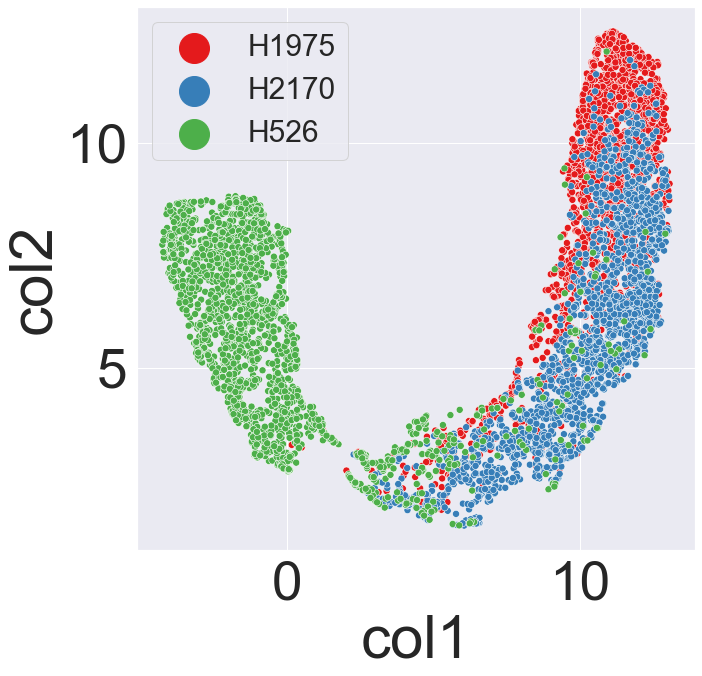

In [128]:
plt.figure(figsize=(10,10))
#plt.axis('off')
sns.scatterplot(data=df_F, x="col1", y="col2", s=50, hue="ClassLabels1", palette=('Set1'))
plt.legend(markerscale=5, fontsize=30)